# CS 7650 - Natural Language - HW2

Georgia Tech, Fall 2024 (Instructor: Kartik Goyal)

<p style="color: red;">DEADLINE: October 28, 2024, 11:59 PM</p>


This is an assignment on Neural Text Generation. We will be implementing a Encoder-Decoder transformer from scratch, and then use it for Machine Translation from German to English. Through the assignment, we will also explore multiple concepts related to Transformers, such as Multi-Head Attention, Positional Encoding, etc., and decoding techniques like Beam Search, Greedy Sampling, Top-k Sampling, etc.

You can refer to the following resources for PyTorch:
- A good tutorial on PyTorch: [Video](https://www.youtube.com/watch?v=OIenNRt2bjg)
- Detailed Documentation of PyTorch: [Docs](https://pytorch.org/docs/stable/index.html)
- Lecture Material on PyTorch and HuggingFace: [GitHub Repository](https://github.com/neelabhsinha/cs7650-gatech-nlp-pytorch-huggingface-tutorial)

Refer to all the `TODO` comments in the code for the parts you need to implement. The total points for this assignment are 100 points. The assignment is divided into the following sections:

1. Load and Preprocess Data [5 points]
2. Transformer Implementation [35 points]
3. Training [10 points]
4. Decoding/Sampling [30 points]
5. Analysis [20 points]
6. Bonus [15 points]

If images are not visible in the notebook, you can find them in the `images` folder in the assignment directory.

## 0. Setup [0 points - Programming]

In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np

import matplotlib.pyplot as plt

import os

In [3]:
# assign a torch random seed for reproducibility
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))
print('Device being used - ', device)

Device being used -  cuda


In [4]:
# execute only if you are working in Google Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Replace this by the folder path where you put your assignment. If you are working with local, skip executing the previous cell and add the path to local directory here.
# folder_path = '.'
folder_path = '/content/drive/My Drive//CS 7650/HW2' # Change the path to the folder where the assignment is stored in Google Drive.

# Files in the folder -
os.listdir(folder_path)

os.chdir(folder_path)

print('Current working directory -', os.getcwd())

Current working directory - /content/drive/My Drive/CS 7650/HW2


In [6]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## 1. Load and Preprocess Data [5 points - Programming]

In this section, you will create DataLoaders for training your transformer model. You are already provided with functions for reading the parallel corpora and building a vocabulary. (Note that we are building *separate* vocabularies for the source and target languages.)

Your task is to implement the `Batch` class and `collate_batch` function in `datautils.py`.  

In [7]:
from datautils import collate_batch, Batch, read_pairs, TranslationDataset, build_vocab

In [8]:
## LOCAL TESTS - DO NOT CHANGE THIS CELL
DATA = os.path.join(os.getcwd(), "data")
# load data
valid_src_path = os.path.join(DATA, "valid.de-en.de")
valid_tgt_path = os.path.join(DATA, "valid.de-en.en")

data = read_pairs(valid_src_path, valid_tgt_path)

# create vocab
src_data = [sent[0] for sent in data]
tgt_data = [sent[1] for sent in data]
src_vocab = build_vocab(src_data, "de")
tgt_vocab = build_vocab(tgt_data, "en")

# create dataset
dataset = TranslationDataset(data, src_vocab, tgt_vocab)
device = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")

Loading de tokens from local file...
Loading en tokens from local file...


### 1.1. Batch Class [3 points - Programming]

The `Batch` class is a simple data structure that holds the source and target sequences, along with the target mask and the number of tokens in the batch. The `Batch` class will be used to store the data for each batch during training.

Implement the `Batch` class in `datautils.py`. Most of the implementation is already added by us, you just need to define the correct mask logic. Feel free to do a disjoint section 2.8. before coming back here, as you can use that function here too (you can do this independently as well, it is not a hard constraint).

In [9]:

# LOCAL TESTS - DO NOT CHANGE THIS CELL

src = torch.tensor([[ 4699.,  4622., 14840., 10188., 13378.,  7845.,  7015., 11664., 13122.,
          2.,  2., 2.]])
tgt = torch.tensor([[ 15820.,  37673., 29931., 21901., 13016., 43304., 2., 2.]])

batch = Batch(src, tgt)

expected_tgt = torch.Tensor([[1.5820e+04, 3.7673e+04, 2.9931e+04, 2.1901e+04, 1.3016e+04, 4.3304e+04,
         2.0000e+00]])

expected_tgt_y = torch.Tensor([[37673., 29931., 21901., 13016., 43304., 2., 2.]])

expected_tgt_mask = torch.Tensor([[
    [ True, False, False, False, False, False, False],
    [ True,  True, False, False, False, False, False],
    [ True,  True,  True, False, False, False, False],
    [ True,  True,  True,  True, False, False, False],
    [ True,  True,  True,  True,  True, False, False],
    [ True,  True,  True,  True,  True,  True, False],
    [ True,  True,  True,  True,  True,  True,  False]]]).to(torch.bool)

expected_ntokens = 5

assert torch.equal(expected_tgt, batch.tgt), "Test Failed: Incorrect values in response for tgt."
assert torch.equal(expected_tgt_y, batch.tgt_y), "Test Failed: Incorrect values in response for tgt_y."
assert torch.allclose(expected_tgt_mask, batch.tgt_mask), "Test Failed: Incorrect values in response for tgt_mask."
assert expected_ntokens == batch.ntokens.item(), "Test Failed: Incorrect values in response for ntokens."
print("Batch - All tests passed.")

Batch - All tests passed.


### 1.2. Data Collation [2 points - Programming]

The `collate_batch` function is responsible for collating a list of samples into a batch. It pads the sequences to the same length, creates the target mask, and computes the number of tokens in the batch. The function returns a `Batch` object containing the source and target sequences, the target mask, and the number of tokens in the batch.

Implement the `collate_batch` function in `datautils.py`.

In [10]:
# LOCAL TESTS - DO NOT CHANGE THIS CELL
batch = [(
    torch.tensor([4699, 4622, 14840, 10188, 13378, 7845, 7015, 11664, 13122, 2896, 4735, 11933]),
    torch.tensor([3541, 488, 2238, 9053, 1028, 5458, 1735, 11248, 8474])
)]

output = collate_batch(batch, device, 16)

expected_src = torch.Tensor([[    0,  4699,  4622, 14840, 10188, 13378,  7845,  7015, 11664, 13122,
          2896,  4735, 11933,     1,     2,     2]]).to(device).to(torch.long)
expected_tgt = torch.Tensor([[    0,  3541,   488,  2238,  9053,  1028,  5458,  1735, 11248,  8474,
             1,     2,     2,     2,     2]]).to(device).to(torch.long)
expected_tgt_y = torch.Tensor([[ 3541,   488,  2238,  9053,  1028,  5458,  1735, 11248,  8474,     1,
             2,     2,     2,     2,     2]]).to(device).to(torch.long)
expected_tgt_mask = torch.Tensor(

).to(device).to(torch.long)

expected_ntokens = 10

assert torch.equal(expected_src, output.src), "Test Failed: Incorrect values in response for src."
assert torch.equal(expected_tgt, output.tgt), "Test Failed: Incorrect values in response for tgt."
assert torch.equal(expected_tgt_y, output.tgt_y), "Test Failed: Incorrect values in response for tgt_y."
# assert torch.allclose(expected_tgt_mask, output.tgt_mask), "Test Failed: Incorrect values in response for tgt_mask."
assert expected_ntokens == output.ntokens.item(), "Test Failed: Incorrect values in response for ntokens."
print("collate_batch - All tests passed.")

collate_batch - All tests passed.


## 2. Transformer Implementation [35 points - Programming]

Transformers have revolutionized the field of natural language processing (NLP) and beyond, offering remarkable improvements in tasks like machine translation, text summarization, and sentiment analysis. Developed by [Vaswani et al. in their 2017 paper, "Attention is All You Need"](https://arxiv.org/abs/1706.03762) , transformers replace traditional recurrent layers with self-attention mechanisms, enabling the model to process input data in parallel and capture complex dependencies across positions.

This assignment is designed to deepen your understanding of transformers by guiding you through the process of implementing one from scratch. By building a transformer model piece by piece, you will gain insights into the architecture’s inner workings, including the attention mechanism, positional encoding, and the overall encoder-decoder structure.

Most of the code related to this section will be implemented in `model.py`. You will be implementing the following classes and functions.

The code break-up as per the famous diagram of transformer can be visualized as below:
<p align="center">
  <img src="images/transformer_layers.png" alt="Transformer">
</p>

The code implementation will be in `model.py`. The tests for the implementation will be in this notebook.


### 2.1. Positional Encoding [3 points - Programming]

The PositionalEncoding module in PyTorch adds necessary positional dynamics to the input embeddings of transformers. Without these encodings, transformers would not be able to utilize the order of the sequence, as they lack any recurrence or convolutional structures inherent in their design.

This module computes a unique encoding for each position in the sequence up to a specified max_len. The encodings use a combination of sine and cosine functions across different dimensions of the embeddings. Specifically, for each dimension i, the encoding alternates between a sine and cosine function:
- Even indices (0, 2, 4, ...) use sine,
- Odd indices (1, 3, 5, ...) use cosine.

The equations are -
$$ PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{2i/d_{\text{model}}}}\right) $$
$$ PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{2i/d_{\text{model}}}}\right) $$

The use of sinusoidal functions helps the model to easily learn to attend by relative positions without much computational overhead. The frequencies of the sine and cosine functions decrease with the dimension, providing a smooth gradient flow for positions that are closer in sequence and differing signals for positions that are further apart.

After computing the positional encodings, they are added directly to the input embeddings. A dropout layer is then applied to the result to reduce overfitting and improve the generalization capabilities of the model during training. The use of dropout is a common regularization technique in neural network training.

Implement the PositionalEncoding class in `model.py`

In [11]:
from model import PositionalEncoding

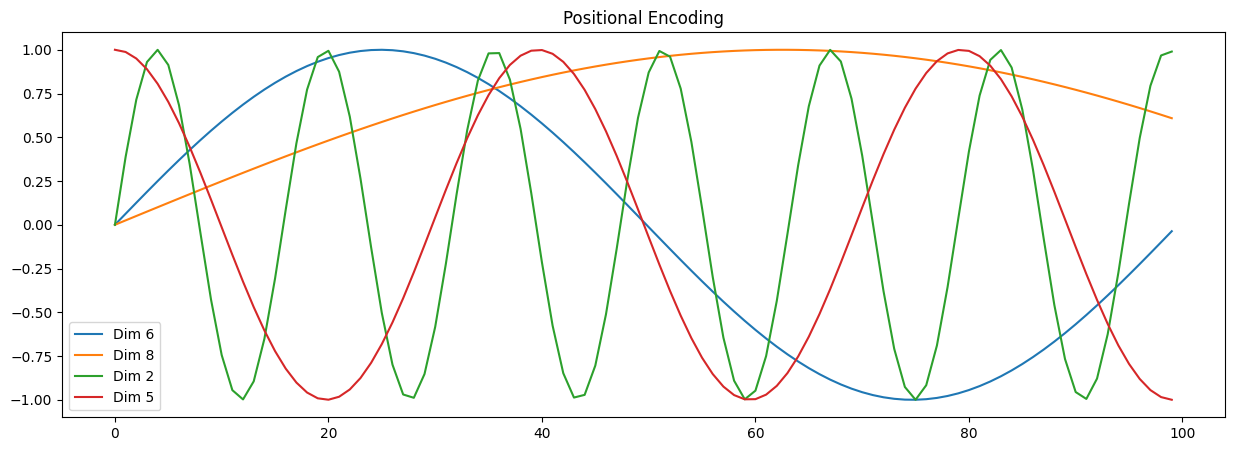

In [12]:
pe = PositionalEncoding(20, 0)
y = pe.forward(torch.zeros(1, 100, 20))


## Visualize your Positional Encodings (feel free to change to other dimensions)

plt.figure(figsize=(15, 5))
plt.plot(np.arange(100), y[0, :, 6].numpy(), label='Dim 6')
plt.plot(np.arange(100), y[0, :, 8].numpy(), label='Dim 8')
plt.plot(np.arange(100), y[0, :, 2].numpy(), label='Dim 2')
plt.plot(np.arange(100), y[0, :, 5].numpy(), label='Dim 5')
plt.legend()
plt.title('Positional Encoding')
plt.show()

In [13]:
## LOCAL TESTS - DO NOT CHANGE THIS CELL
pe = PositionalEncoding(4, 0)
y = pe.forward(torch.zeros(1, 5, 4))
expected_output = torch.tensor([[[ 0.0000,  1.0000,  0.0000,  1.0000],
         [ 0.8415,  0.5403,  0.0100,  0.9999],
         [ 0.9093, -0.4161,  0.0200,  0.9998],
         [ 0.1411, -0.9900,  0.0300,  0.9996],
         [-0.7568, -0.6536,  0.0400,  0.9992]]])
assert y.shape == (1, 5, 4), "Test Failed: Incorrect shape of obtained response."
assert torch.allclose(y, expected_output, atol=1e-4), "Test Failed: Incorrect values in response for positional encoding without dropout."

pe = PositionalEncoding(2, 0.1)
x = torch.tensor([[[1, 2], [4, 5]]], dtype=torch.float32)
y = pe.forward(x)
expected_output = torch.tensor([[[1.1111, 3.3333],
         [5.3794, 6.1559]]]
)
assert y.shape == (1, 2, 2), "Test Failed: Incorrect shape of obtained response."
assert torch.allclose(y, expected_output, atol=1e-4), "Test Failed: Incorrect values in response for positional encoding with dropout."

print("Positional Encoding - All tests passed.")


Positional Encoding - All tests passed.


### 2.2. Embeddings [3 points - Programming]

The Embeddings provide functionality to transform token indices into dense embeddings. It also scales these embeddings by the square root of the embedding dimension. This scaling is crucial as it helps in maintaining a consistent variance across the embeddings, which is beneficial for stabilizing gradients during training.

This is the same embedding as HW1, with slight change (as you will see in the docstring of the class).

Implement the Embeddings class in `model.py`

In [14]:
## LOCAL TESTS - DO NOT CHANGE THIS CELL
from model import Embeddings

emb = Embeddings(5, 5)
emb.set_embedding_weights()
x = torch.tensor([[1, 2, 3, 4, 0], [4, 3, 2, 1, 0]])
y = emb(x)
expected_output = torch.tensor([[[0.0000, 0.5590, 1.1180, 1.6771, 2.2361],
         [0.0000, 0.5590, 1.1180, 1.6771, 2.2361],
         [0.0000, 0.5590, 1.1180, 1.6771, 2.2361],
         [0.0000, 0.5590, 1.1180, 1.6771, 2.2361],
         [0.0000, 0.5590, 1.1180, 1.6771, 2.2361]],

        [[0.0000, 0.5590, 1.1180, 1.6771, 2.2361],
         [0.0000, 0.5590, 1.1180, 1.6771, 2.2361],
         [0.0000, 0.5590, 1.1180, 1.6771, 2.2361],
         [0.0000, 0.5590, 1.1180, 1.6771, 2.2361],
         [0.0000, 0.5590, 1.1180, 1.6771, 2.2361]]])

assert y.shape == (2, 5, 5), "Test Failed: Incorrect shape of obtained response."
assert torch.allclose(y, expected_output, atol=1e-4), "Test Failed: Incorrect values in response for embeddings."
print("Embeddings - All tests passed.")

Embeddings - All tests passed.


### 2.3. Scaled Dot-Product Attention [3 points - Programming]

The attention function is an implementation of the Scaled Dot Product Attention mechanism, which is crucial for models that include transformers. This function calculates attention weights and applies these weights to the values based on the input queries and keys. The attention mechanism allows the model to focus on different parts of the input sequence, enabling it to capture complex dependencies and relationships between tokens.

The Scaled Dot Product Attention function is defined as follows:
$$ \text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V $$

Here, Q, K, and V are the query, key, and value matrices, respectively. The function first computes the dot product of the query and key matrices, scales the result by the square root of the key dimension, and then applies a softmax function to obtain the attention weights. Finally, the function multiplies the attention weights by the value matrix to produce the output.

<p align="center">
  <img src="images/scaled_dot_product_attention.png" alt="Scaled Dot-product Attention">
</p>



Implement the `attention()` function in `model.py`

In [15]:
# LOCAL TESTS - DO NOT CHANGE THIS CELL
from model import attention

q = torch.tensor([[[[1, 2, 3], [2, 1, 2], [3, 2, 1]],[[1, 3, 2], [2, 2, 1], [1, 2, 3]]]], dtype=torch.float32)
k = torch.tensor([[[[1, 3, 1], [4, 1, 2], [3, 2, 1]], [[3, 1, 2], [1, 4, 2], [4, 2, 1]]]], dtype=torch.float32)
v = torch.tensor([[[[3, 1, 2], [1, 2, 1], [2, 1, 3]], [[1, 3, 2], [2, 1, 3], [3, 2, 1]]]], dtype=torch.float32)

attended_values, attention_weights = attention(q, k, v)
expected_attended_values_1 = torch.tensor([[[[1.5799, 1.6134, 1.5799],
          [1.1982, 1.8277, 1.3188],
          [1.2806, 1.7427, 1.4914]],
         [[2.0356, 1.0847, 2.8797],
          [2.4735, 1.7788, 1.7477],
          [2.0000, 1.2486, 2.7514]]]])
expected_attention_weights_1 = torch.tensor([[[[0.1933, 0.6134, 0.1933],
          [0.0259, 0.8277, 0.1464],
          [0.0232, 0.7427, 0.2341]],
         [[0.0164, 0.9317, 0.0519],
          [0.1018, 0.3229, 0.5753],
          [0.0829, 0.8343, 0.0829]]]])
assert torch.allclose(attended_values, expected_attended_values_1, atol=1e-4), "Test Failed: Incorrect values in response for Test Case 1 (no dropout, no mask)."
assert torch.allclose(attention_weights, expected_attention_weights_1, atol=1e-4), "Test Failed: Incorrect values in response for Test Case 1 (no dropout, no mask)."
# Evaluate the effect of mask
mask = torch.tensor([[[[1, 1, 1],
                       [1, 1, 0],
                       [1, 0, 0]]]], dtype=torch.float32)
attended_values, attention_weights = attention(q, k, v, mask)
expected_attended_values_2 = torch.tensor([[[[1.5799, 1.6134, 1.5799],
          [1.0607, 1.9696, 1.0304],
          [3.0000, 1.0000, 2.0000]],
         [[2.0356, 1.0847, 2.8797],
          [1.7604, 1.4793, 2.7604],
          [1.0000, 3.0000, 2.0000]]]])
expected_attention_weights_2 = torch.tensor([[[[0.1933, 0.6134, 0.1933],
          [0.0304, 0.9696, 0.0000],
          [1.0000, 0.0000, 0.0000]],
         [[0.0164, 0.9317, 0.0519],
          [0.2396, 0.7604, 0.0000],
          [1.0000, 0.0000, 0.0000]]]])
assert torch.allclose(attended_values, expected_attended_values_2, atol=1e-4), "Test Failed: Incorrect values in response for Test Case 2 (no dropout but mask present)."
assert torch.allclose(attention_weights, expected_attention_weights_2, atol=1e-4), "Test Failed: Incorrect values in response for Test Case 2 (no dropout but mask present)."
# Evaluate the effect of dropout
dropout = torch.nn.Dropout(p=0.3)
attended_values_1, attention_weights_1 = attention(q, k, v, dropout=dropout, mask=mask)
attended_values_2, attention_weights_2 = attention(q, k, v, dropout=dropout, mask=mask)
assert not torch.allclose(attention_weights_1, attention_weights_2, atol=1e-4), "Test Failed: Incorrect results with dropout."
assert not torch.allclose(attended_values_1, attended_values_2, atol=1e-4), "Test Failed: Incorrect results with dropout."
print("Scaled Dot-Product Attention - All tests passed.")

Scaled Dot-Product Attention - All tests passed.


### 2.4. Multi-Head Attention [3 points - Programming]

The MultiHeadedAttention class encapsulates the multi-head attention mechanism, a pivotal component in transformer architectures. This mechanism allows the model to attend to different parts of the input sequence simultaneously, making it highly effective for tasks involving complex dependencies.

Key Features:

- Parallel Attention Heads: Each head independently computes attention, focusing on different features of the input. The results from each head are then combined to capture a richer representation.
- Dimensionality: The input dimensions are projected into smaller, separate dimensions for each head $(d_k)$, speeding up computation and allowing diverse representations.
- Scalability: By separating the input into multiple heads, the model can scale attention across different subspaces, enhancing learning capabilities and model performance.

<p align="center">
  <img src="images/multihead_attention.png" alt="Multihead Attention">
</p>

In `model.py`, implement the `MultiHeadedAttention` class.

In [16]:
# LOCAL TESTS - DO NOT CHANGE THIS CELL
from model import MultiHeadedAttention
q = torch.tensor([[[1, 2, 3], [2, 1, 2], [3, 2, 1]], [[1, 3, 2], [2, 2, 1], [1, 2, 3]]], dtype=torch.float32)
k = torch.tensor([[[1, 3, 1], [4, 1, 2], [3, 2, 1]], [[3, 1, 2], [1, 4, 2], [4, 2, 1]]], dtype=torch.float32)
v = torch.tensor([[[3, 1, 2], [1, 2, 1], [2, 1, 3]], [[1, 3, 2], [2, 4, 3], [3, 2, 1]]], dtype=torch.float32)
mha = MultiHeadedAttention(3, 3, dropout=0.0)
weights = torch.tensor([[[1, 2, 1], [1, 1, 2], [2, 1, 1]], [[1, 3, 1], [1, 3, 2], [2, 4, 1]], [[1, 2, 3], [1, 4, 2], [2, 3, 1]], [[1, 4, 3], [1, 1, 4], [4, 3, 1]]], dtype=torch.float32)
biases = torch.tensor([[1, 2, 4], [1, 3, 5], [2, 5, 1], [4, 1, 3]], dtype=torch.float32)
mha.set_weights(weights, biases)
out = mha(q, k, v)
expected_output = torch.tensor([[[115.5003,  76.0002, 114.5010],
         [115.5023,  76.0019, 114.5076],
         [115.5007,  76.0004, 114.5014]],
        [[201.0000, 131.0000, 194.0000],
         [201.0000, 131.0000, 194.0000],
         [201.0000, 131.0000, 194.0000]]])
assert out.shape == (2, 3, 3), "Test Failed: Incorrect shape of obtained response."
assert torch.allclose(out, expected_output, atol=1e-4), "Test Failed: Incorrect results without dropout."
mha = MultiHeadedAttention(3, 3, dropout=0.5)
out_1 = mha(q, k, v)
out_2 = mha(q, k, v)
assert not torch.allclose(out_1, out_2, atol=1e-4), "Test Failed: Incorrect results with dropout."
print("MultiHeadedAttention - All tests passed.")

MultiHeadedAttention - All tests passed.


### 2.5. Feed-Forward Layer [3 points - Programming]

In both the encoder and decoder of our model, each layer includes a fully connected feed-forward network. This network operates independently on each position and follows the same structure throughout. It is composed of two linear transformations. Between these transformations, a ReLU activation function is applied to introduce non-linearity.

$$ \text{FFN}(x) = \text{ReLU}(xW_1 + b_1)W_2 + b_2 $$

Implement the `FeedForward` class in `model.py`.

In [17]:
# LOCAL TESTS - DO NOT CHANGE THIS CELL
from model import FeedForward
x = torch.tensor([[[1, 2, 3], [2, 1, 2], [3, 2, 1]], [[1, 3, 2], [2, 2, 1], [1, 2, 3]]], dtype=torch.float32)
ffn = FeedForward(3, 3, 0.0)
weights = torch.tensor([[[1, 2, 1], [1, 1, 2], [2, 1, 1]], [[1, 3, 1], [4, 3, 2], [2, 2, 1]]], dtype=torch.float32)
biases = torch.tensor([[1, 2, 4], [2, 2, 3]], dtype=torch.float32)
ffn.set_weights(weights, biases)
out = ffn(x)
expected_output = torch.tensor([[[55., 93., 54.],
         [47., 79., 46.],
         [51., 91., 52.]],
        [[53., 94., 54.],
         [45., 80., 46.],
         [55., 93., 54.]]])
assert out.shape == (2, 3, 3), "Test Failed: Incorrect shape of obtained response."
assert torch.allclose(out, expected_output, atol=1e-4), "Test Failed: Incorrect results without dropout."
ffn = FeedForward(3, 3, 0.5)
out_1 = ffn(x)
out_2 = ffn(x)
assert not torch.allclose(out_1, out_2, atol=1e-4), "Test Failed: Incorrect results with dropout."
print("FeedForward - All tests passed.")

FeedForward - All tests passed.


### 2.6. Layer Normalization [3 points - Programming]

Layer normalization is a technique that normalizes the inputs across the features instead of the batch. It is very effective for stabilizing the learning process in networks that are deep or use complex recurrent structures. The normalization process adjusts the input data in such a way that the mean output per feature vector over a training batch is zero and the standard deviation is one. This is particularly beneficial in models like transformers where the batch size can often vary.

Layer normalization differs from batch normalization as it normalizes across the features for each single sample, and not across the batch dimension. It is extensively used in transformer models.

You can read more about Layer Normalization [here](https://arxiv.org/abs/1607.06450).

Equation -
$$ y = \alpha \odot \frac{x - \mu}{\sigma + \epsilon} + \beta $$

Where:
- x is the input tensor.
- μ is the mean computed over the last dimension.
- σ is the standard deviation computed over the last dimension.
- α is a learnable parameter scaling each feature.
- β is a learnable parameter shifting each feature.
- ϵ is a small constant (epsilon) added for numerical stability.

Implement the `LayerNorm` class in `model.py`.

In [18]:
# LOCAL TESTS - DO NOT CHANGE THIS CELL
from model import LayerNorm

x = torch.tensor([[[1, 2, 3], [2, 1, 2], [3, 2, 1]], [[1, 3, 2], [2, 2, 1], [1, 2, 3]]], dtype=torch.float32)
ln = LayerNorm(3)
out = ln(x)
expected_output = torch.tensor([[[-1.0000,  0.0000,  1.0000],
         [ 0.5773, -1.1547,  0.5773],
         [ 1.0000,  0.0000, -1.0000]],
        [[-1.0000,  1.0000,  0.0000],
         [ 0.5773,  0.5773, -1.1547],
         [-1.0000,  0.0000,  1.0000]]])
assert out.shape == (2, 3, 3), "Test Failed: Incorrect shape of obtained response."
assert torch.allclose(out, expected_output, atol=1e-4), "Test Failed: Incorrect results."
print("LayerNorm - All tests passed.")


LayerNorm - All tests passed.


### 2.7. Residual Stream Block [3 points - Programming]

The Residual Stream Block is designed to encapsulate two primary functionalities essential in modern neural network architectures: normalization and residual connections. This combination is particularly popular in transformer models and helps combat the vanishing gradient problem in deep networks.

- Layer Normalization: This step normalizes the input tensor's features to have zero mean and unit variance, which stabilizes learning by making the model less sensitive to different input scales.
- Residual Connection: The residual connection allows gradients to flow through the network directly by adding the input tensor x to the output of a transformation applied to x. This skip-connection technique is critical for training deeper networks efficiently.
- Dropout: Integrated into the pathway, dropout is a regularization technique that "drops out" random neuron outputs during training to prevent overfitting and encourage robust internal representations.

Implement the `ResidualStreamBlock` class in `model.py`.

In [19]:
# LOCAL TESTS - DO NOT CHANGE THIS CELL
from model import ResidualStreamBlock
x = torch.tensor([[[1, 2, 3], [2, 1, 2], [3, 2, 1]], [[1, 3, 2], [2, 2, 1], [1, 2, 3]]], dtype=torch.float32)
linear = torch.nn.Linear(3, 3, bias=False)
linear.weight.data = torch.tensor([[1, 2, 1], [1, 1, 2], [2, 1, 1]], dtype=torch.float32)
scl = ResidualStreamBlock(3, 0.0)
out = scl(x, linear)
expected_output = torch.tensor([[[1.0000, 3.0000, 2.0000],
         [0.8453, 1.5773, 2.5773],
         [3.0000, 1.0000, 2.0000]],
        [[2.0000, 3.0000, 1.0000],
         [2.5773, 0.8453, 1.5773],
         [1.0000, 3.0000, 2.0000]]])
assert out.shape == (2, 3, 3), "Test Failed: Incorrect shape of obtained response."
assert torch.allclose(out, expected_output, atol=1e-4), "Test Failed: Incorrect results without dropout."
scl = ResidualStreamBlock(3, 0.5)
out_1 = scl(x, linear)
out_2 = scl(x, linear)
assert not torch.allclose(out_1, out_2, atol=1e-4), "Test Failed: Incorrect results with dropout."
print("ResidualStreamBlock - All tests passed.")


ResidualStreamBlock - All tests passed.


### 2.8. Autoregressive Masking [3 points - Programming]

An autoregressive mask generates a boolean mask used to control the flow of information in the sequence. This mask that output at a certain position in a sequence is only dependent on the previous positions and not any future positions. This mechanism is crucial in tasks like sequence generation where the model should not have access to future input during training.

Implement the `autoregressive_mask` function in `model.py`.

In [20]:
# LOCAL TESTS - DO NOT CHANGE THIS CELL
from model import autoregressive_mask
mask = autoregressive_mask(3)
expected_output = torch.tensor([[[1, 0, 0],
         [1, 1, 0],
         [1, 1, 1]]], dtype=torch.bool)
assert mask.shape == (1, 3, 3), "Test Failed: Incorrect shape of obtained response."
assert torch.allclose(mask, expected_output, atol=1e-4), "Test Failed: Incorrect results."
mask = autoregressive_mask(7)
expected_output = torch.tensor([[[1, 0, 0, 0, 0, 0, 0],
         [1, 1, 0, 0, 0, 0, 0],
         [1, 1, 1, 0, 0, 0, 0],
         [1, 1, 1, 1, 0, 0, 0],
         [1, 1, 1, 1, 1, 0, 0],
         [1, 1, 1, 1, 1, 1, 0],
         [1, 1, 1, 1, 1, 1, 1]]], dtype=torch.bool)
assert mask.shape == (1, 7, 7), "Test Failed: Incorrect shape of obtained response."
assert torch.allclose(mask, expected_output, atol=1e-4), "Test Failed: Incorrect results."
print("Subsequent Mask - All tests passed.")

Subsequent Mask - All tests passed.


These are the basic building blocks of the Transformer model. In the next sections, we will implement the Encoder and Decoder classes, and then combine them to create the full Transformer model.
Note, the encoder-decoder transformer is the fundamental form of transformer with self-attention and cross-attention. It is widely used in machine translation tasks, or summarization tasks.

Apart from there, there are also encoder-only transformers, and decoder-only transformers. The encoder-only transformers are used in tasks like language modeling, where the model is trained to predict the next word in a sequence. The decoder-only transformers are used in tasks like text generation, where the model is trained to generate a sequence of words given an input sequence.

BERT is an example of an encoder-only transformer, while GPT is an example of a decoder-only transformer. In this assignment, we will be implementing the encoder-decoder transformer. Some encoder-decoder transformers are BART, T5, etc.

Let's move to utilizing the building blocks we have implemented so far to create the Encoder and Decoder classes, and then combine them to create the full Transformer model.

### 2.9. Transformer Encoder Block [3 points - Programming]

It is designed to encapsulate two main submodules: self-attention and a feed-forward network.

- Self-attention Module: This module allows each position in the encoder to attend to all positions in the previous layer of the encoder, which captures intricate dependencies in the input data regardless of their distance in the input sequence. This is an instance of multi-head attention, where the query, key, and value inputs are all derived from the same input.
- Feed-forward Network: Each position is separately and identically processed by the feed-forward network, which typically consists of two linear transformations with a ReLU activation in between. This is the same feed-forward network we implemented earlier.
- Sublayer Connections: Each of these components is embedded in a ResidualStreamBlock, which applies a residual connection followed by layer normalization. This design promotes direct pathways for gradients during training, facilitating the training of deep networks. This is the same sublayer connection we implemented earlier.

Process Flow in forward Method:
- The input tensor x is first passed through the self-attention mechanism within a sublayer connection, which also uses a mask to ignore certain positions (useful for handling padded positions in sequences).
- The output of the self-attention is then passed through the feed-forward network within another sublayer connection.
- This structure effectively allows the encoder to enhance its representation capabilities with depth, leveraging both self-attention and dense layers, while maintaining stability through normalization and residual connections.

Implement the `EncoderBlock` class in `model.py`.

In [21]:
# LOCAL TESTS - DO NOT CHANGE THIS CELL
from model import EncoderBlock
from model import MultiHeadedAttention, FeedForward
x = torch.tensor([[[1, 2, 3], [2, 1, 2], [3, 2, 1]], [[1, 3, 2], [2, 2, 1], [1, 2, 3]]], dtype=torch.float32)
mha = MultiHeadedAttention(3, 3, dropout=0.0)
weights = torch.tensor([[[1, 2, 1], [1, 1, 2], [2, 1, 1]], [[1, 3, 1], [1, 3, 2], [2, 4, 1]], [[1, 2, 3], [1, 4, 2], [2, 3, 1]], [[1, 4, 3], [1, 1, 4], [4, 3, 1]]], dtype=torch.float32)
biases = torch.tensor([[1, 2, 4], [1, 3, 5], [2, 5, 1], [4, 1, 3]], dtype=torch.float32)
mha.set_weights(weights, biases)
ffn = FeedForward(3, 3, 0.0)
weights = torch.tensor([[[1, 2, 1], [1, 1, 2], [2, 1, 1]], [[1, 3, 1], [4, 3, 2], [2, 2, 1]]], dtype=torch.float32)
biases = torch.tensor([[1, 2, 4], [2, 2, 3]], dtype=torch.float32)
ffn.set_weights(weights, biases)
eb = EncoderBlock(3, mha, ffn, 0.0)
mask = None
out = eb(x, mask)
expected_output = torch.tensor([[[50.9330, 37.6713, 46.5334],
         [51.7019, 36.5467, 45.3967],
         [50.7294, 36.9257, 42.9702]],

        [[59.8909, 43.0178, 53.5605],
         [58.5936, 41.4671, 50.4271],
         [60.3661, 41.9595, 54.0644]]])

assert out.shape == (2, 3, 3), "Test Failed: Incorrect shape of obtained response."
assert torch.allclose(out, expected_output, atol=1e-4), "Test Failed: Incorrect results without dropout."
eb = EncoderBlock(3, mha, ffn, 0.5)
out_1 = eb(x, mask)
out_2 = eb(x, mask)
assert not torch.allclose(out_1, out_2, atol=1e-4), "Test Failed: Incorrect results with dropout."
print("EncoderBlock - All tests passed.")

EncoderBlock - All tests passed.


### 2.10. Transformer Encoder

The encoder consists of a stack of identical layers, each of which may involve operations such as self-attention and feed-forward transformations. Each layer is expected to maintain a consistent interface and dimensionality, specified by the size attribute. After data passes through all the layers, a final layer normalization is applied. This step is crucial as it ensures that the outputs of the encoder are normalized, reducing the risk of instability in gradients and aiding in faster convergence.

The forward method illustrates the sequential processing of the input $x$ through each layer in the stack, with an optional mask applied at each step. The mask is typically used to nullify the effects of padding in sequence data, ensuring that padding does not influence the learning process. By allowing the encoder to stack an arbitrary number of identical layers, this design supports scalability and depth in model architecture, enabling it to learn more complex features and relationships in data.

This implementation is streamlined yet flexible, accommodating any layer structure that fits the defined interface, making it a versatile component in advanced neural network architectures.

Implement the `Encoder` class in `model.py`.
There are no local tests for this cell due to large complexity in initializations. The implementation only requires stacking the EncoderBlock, and reusing existing classes.

In [22]:
# EXECUTION CHECK
from model import Encoder, EncoderBlock, MultiHeadedAttention, FeedForward
x = torch.tensor([[[1, 2, 3], [2, 1, 2], [3, 2, 1]], [[1, 3, 2], [2, 2, 1], [1, 2, 3]]], dtype=torch.float32)
encoder_block = EncoderBlock(3, MultiHeadedAttention(3, 3, dropout=0.0), FeedForward(3, 3, 0.0), 0.0)
encoder = Encoder(encoder_block, 2)

print(encoder)

# Try to map this to the transformers architecture diagram and understand if you have got the entire encoder.


Encoder(
  (layers): ModuleList(
    (0-1): 2 x EncoderBlock(
      (self_attn): MultiHeadedAttention(
        (linears): ModuleList(
          (0-3): 4 x Linear(in_features=3, out_features=3, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (feed_forward): FeedForward(
        (w_1): Linear(in_features=3, out_features=3, bias=True)
        (w_2): Linear(in_features=3, out_features=3, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (residual_stream_block1): ResidualStreamBlock(
        (norm): LayerNorm()
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (residual_stream_block2): ResidualStreamBlock(
        (norm): LayerNorm()
        (dropout): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm()
)


### 2.11. Transformer Decoder Block [3 points - Programming]

The Decoder block in transformer models is designed to process the output from the encoder and generate a sequence output in tasks like translation or text generation. Each decoder layer contains three key sub-modules:
- a self-attention mechanism, which helps the decoder focus on relevant parts of the input sequence
- a cross-attention mechanism, allowing the decoder to attend to the entire output of the encoder
- a position-wise feed-forward network, which applies a set of fully connected layers to each position independently.

These sub-modules are encapsulated within a framework that includes residual connections and layer normalization, crucial for stabilizing the learning process and enabling deeper model architectures. Understanding these components is essential for students delving into how transformers maintain context and generate coherent outputs in sequence-to-sequence tasks.

Implement the `DecoderBlock` class in `model.py`.

In [23]:
# LOCAL TESTS - DO NOT CHANGE THIS CELL
from model import DecoderBlock, MultiHeadedAttention, FeedForward, ResidualStreamBlock, autoregressive_mask
x = torch.tensor([[[1, 2, 3], [2, 1, 2], [3, 2, 1]], [[1, 3, 2], [2, 2, 1], [1, 2, 3]]], dtype=torch.float32)
mha_self = MultiHeadedAttention(3, 3, dropout=0.0)
weights = torch.tensor([[[1, 2, 1], [1, 1, 2], [2, 1, 1]], [[1, 3, 1], [1, 3, 2], [2, 4, 1]], [[1, 2, 3], [1, 4, 2], [2, 3, 1]], [[1, 4, 3], [1, 1, 4], [4, 3, 1]]], dtype=torch.float32)
biases = torch.tensor([[1, 2, 4], [1, 3, 5], [2, 5, 1], [4, 1, 3]], dtype=torch.float32)
mha_self.set_weights(weights, biases)
mha_cross = MultiHeadedAttention(3, 3, dropout=0.0)
weights = torch.tensor([[[1, 2, 1], [1, 1, 2], [2, 9, 1]], [[1, 3, 1], [4, 3, 2], [2, 2, 1]], [[5, 2, 1], [1, 3, 2], [2, 1, 1]], [[1, 3, 0], [4, 3, 2], [2, 2, 6]]], dtype=torch.float32)
biases = torch.tensor([[1, 2, 2], [1, 3, 7], [2, 5, 4], [4, 9, 3]], dtype=torch.float32)
mha_cross.set_weights(weights, biases)
ffn = FeedForward(3, 3, 0.0)
weights = torch.tensor([[[1, 2, 1], [1, 1, 2], [2, 1, 1]], [[1, 3, 1], [4, 3, 2], [2, 2, 1]]], dtype=torch.float32)
biases = torch.tensor([[1, 2, 4], [2, 2, 3]], dtype=torch.float32)
ffn.set_weights(weights, biases)
db = DecoderBlock(3, mha_self, mha_cross, ffn, 0.0)
src_mask = None
tgt_mask = autoregressive_mask(3)
memory = torch.tensor([[[1, 1, 0], [2, 3, 1], [1, 2, 1]], [[1, 1, 1], [3, 2, 1], [1, 2, 4]]], dtype=torch.float32)
out = db(x, memory, src_mask, tgt_mask)

expected_output = torch.tensor([[[117.3262, 158.9924, 158.8624],
         [116.6737, 155.3791, 152.4066],
         [121.2165, 166.5353, 150.3511]],
        [[126.4522, 174.3401, 168.4910],
         [127.5165, 177.1474, 165.8177],
         [127.0625, 175.4266, 167.4181]]])

assert out.shape == (2, 3, 3), "Test Failed: Incorrect shape of obtained response."
assert torch.allclose(out, expected_output, atol=1e-4), "Test Failed: Incorrect results without dropout."
db = DecoderBlock(3, mha_self, mha_cross, ffn, 0.5)
out_1 = db(x, memory, src_mask, tgt_mask)
out_2 = db(x, memory, src_mask, tgt_mask)
assert not torch.allclose(out_1, out_2, atol=1e-4), "Test Failed: Incorrect results with dropout."
print("DecoderBlock - All tests passed.")

DecoderBlock - All tests passed.


### 2.12. Transformer Decoder

The decoder consists of a stack of identical decoder blocks. Each layer is expected to maintain a consistent interface and dimensionality, specified by the size attribute. After data passes through all the layers, a final layer normalization is applied.

Decoder is constructed with DecoderBlock just the same way as Encoder is constructed with EncoderBlock.

Implement the `Decoder` class in `model.py`.

There are no local tests for this cell due to large complexity in initializations. The implementation only requires stacking the `DecoderBlock`, and reusing existing classes.

In [24]:
# EXECUTION CHECK
from model import Decoder, DecoderBlock, MultiHeadedAttention, FeedForward, ResidualStreamBlock, autoregressive_mask
x = torch.tensor([[[1, 2, 3], [2, 1, 2], [3, 2, 1]], [[1, 3, 2], [2, 2, 1], [1, 2, 3]]], dtype=torch.float32)
decoder_block = DecoderBlock(3, MultiHeadedAttention(3, 3, dropout=0.0), MultiHeadedAttention(3, 3, dropout=0.0), FeedForward(3, 3, 0.0), 0.0)
decoder = Decoder(decoder_block, 2)

print(decoder)

Decoder(
  (layers): ModuleList(
    (0-1): 2 x DecoderBlock(
      (self_attn): MultiHeadedAttention(
        (linears): ModuleList(
          (0-3): 4 x Linear(in_features=3, out_features=3, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (cross_attn): MultiHeadedAttention(
        (linears): ModuleList(
          (0-3): 4 x Linear(in_features=3, out_features=3, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (feed_forward): FeedForward(
        (w_1): Linear(in_features=3, out_features=3, bias=True)
        (w_2): Linear(in_features=3, out_features=3, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (residual_stream_block1): ResidualStreamBlock(
        (norm): LayerNorm()
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (residual_stream_block2): ResidualStreamBlock(
        (norm): LayerNorm()
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (residual_stream_

### 2.13. Generator [3 points - Programming]

The Generator class serves as the final component of the decoder output pipeline, transforming high-dimensional decoder outputs into a probability distribution over a predefined vocabulary. It achieves this by employing a linear transformation that maps the decoder's feature space to the vocabulary space, followed by a log softmax function. The log softmax ensures the output values are log probabilities, which are more numerically stable for the computation of loss functions like cross-entropy during training. Understanding the mechanics of the Generator is crucial for those looking to delve into the specifics of neural output generation, particularly how models like Transformers predict the next sequence of tokens in a given task.

Implement the `Generator` class in `model.py`.

In [25]:
# LOCAL TESTS - DO NOT CHANGE THIS CELL
from importlib import reload
import model
reload(model)

from model import Generator

generator = Generator(3, 10)
weight = torch.tensor([[1, 2, 1], [1, 1, 2], [2, 1, 1], [1, 3, 1], [1, 3, 2], [2, 4, 1], [5, 2, 1], [1, 3, 2], [2, 1, 1], [1, 3, 0]], dtype=torch.float32)
bias = torch.tensor([1, 2, 4, 2, 2, 3, 2, 5, 4, 9], dtype=torch.float32)

x = torch.tensor([[[1, 2, 3], [2, 1, 2], [3, 2, 1]], [[1, 3, 2], [2, 2, 1], [1, 2, 3]]], dtype=torch.float32)

generator.set_weights(weight, bias)
out = generator(x)
expected_output = torch.tensor([[[ -9.2957,  -7.2957,  -7.2957,  -6.2957,  -3.2957,  -2.2957,  -4.2957,
           -0.2957,  -7.2957,  -2.2957],
         [ -9.2946,  -7.2946,  -5.2946,  -7.2946,  -5.2946,  -3.2946,  -0.2946,
           -2.2946,  -5.2946,  -2.2946],
         [-13.0388, -13.0388,  -9.0388, -10.0388,  -9.0388,  -4.0388,  -0.0388,
           -6.0388,  -9.0388,  -4.0388]],
        [[-10.1236, -10.1236,  -9.1236,  -6.1236,  -4.1236,  -1.1236,  -5.1236,
           -1.1236,  -9.1236,  -1.1236],
         [ -9.9233,  -9.9233,  -6.9233,  -6.9233,  -5.9233,  -1.9233,  -0.9233,
           -2.9233,  -6.9233,  -0.9233],
         [ -9.2957,  -7.2957,  -7.2957,  -6.2957,  -3.2957,  -2.2957,  -4.2957,
           -0.2957,  -7.2957,  -2.2957]]])

assert out.shape == (2, 3, 10), "Test Failed: Incorrect shape of obtained response."
assert torch.allclose(out, expected_output, atol=1e-4), "Test Failed: Incorrect results."
print("Generator - All tests passed.")

Generator - All tests passed.


### 2.14. The Complete Transformer

Great, we have now implemented all components of the Transformer model. Before we move ahead, feel free to map your implementations to the diagram of the transformer. It will make a lot of things clear going forward.

Let's now combine these components to create the full Transformer model. The Transformer model consists of an encoder, a decoder, and a generator. The encoder processes the input sequence, the decoder generates the output sequence, and the generator converts the decoder output into a probability distribution over the vocabulary.

Implement the `Transformer` class in `model.py`.

Like the Encoder and Decoder, this also won't have local tests due to the complexity in initializations.

After this, to complete the model definition, thoroughly go through the `make_model()` function in `model.py`. This function will create an instance of the Transformer model with the specified hyperparameters.

### 2.15. Inference Test on Untrained Transformer [2 points - Programming]

Let's run a dummy inference on an untrained transformer to check if things are fine.

In [26]:
# LOCAL TESTS - DO NOT CHANGE THIS CELL
from model import make_model
def inference_test():
    test_model = make_model(11, 11, 2)
    test_model.eval()
    src = torch.LongTensor([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]])
    src_mask = torch.ones(1, 1, 10)

    memory = test_model.encode(src, src_mask)
    ys = torch.zeros(1, 1).type_as(src)

    for i in range(9):
        out = test_model.decode(
            memory, src_mask, ys, autoregressive_mask(ys.size(1)).type_as(src.data)
        )
        prob = test_model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data[0]
        ys = torch.cat(
            [ys, torch.empty(1, 1).type_as(src.data).fill_(next_word)], dim=1
        )

    print("Example Untrained Model Prediction:", ys)


def run_tests():
    for _ in range(10):
        inference_test()

def show_example(fn, args=[]):
        return fn(*args)

show_example(run_tests)

Example Untrained Model Prediction: tensor([[0, 7, 7, 7, 7, 7, 7, 7, 7, 7]])
Example Untrained Model Prediction: tensor([[0, 4, 7, 4, 7, 4, 7, 0, 7, 0]])
Example Untrained Model Prediction: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
Example Untrained Model Prediction: tensor([[0, 6, 4, 5, 7, 7, 7, 7, 7, 7]])
Example Untrained Model Prediction: tensor([[ 0,  4,  5,  5, 10,  6,  0,  4,  5,  5]])
Example Untrained Model Prediction: tensor([[ 0, 10,  8,  0, 10,  8,  0,  0,  0, 10]])
Example Untrained Model Prediction: tensor([[0, 5, 3, 8, 9, 3, 8, 3, 8, 3]])
Example Untrained Model Prediction: tensor([[0, 0, 7, 0, 0, 7, 0, 0, 0, 0]])
Example Untrained Model Prediction: tensor([[ 0,  4, 10, 10, 10, 10, 10, 10, 10, 10]])
Example Untrained Model Prediction: tensor([[0, 8, 7, 2, 6, 2, 6, 2, 6, 2]])


---

## 3. Model Training [5 points - Programming + 5 points - Non-programming]

In this section, we will implement the training loop for the Transformer model. We will also implement the label smoothing technique to regularize the model during training.
We have already provided most of the training utils that we asked you to implement during previous homeworks. You can find them in `utils.py`, `model_training.py` and `datautils.py`. Some of the implementations will be done by you in this section.

### 3.1 Label Smoothing [5 points - Programming]

The label smoothing loss (introduced in [Szegedy 2015](https://arxiv.org/pdf/1512.00567)) is a regularization technique used to prevent the model from overfitting to the training data. The label smoothing loss is implemented in the `LabelSmoothing` class in the `utils.py` file.

Let's say the model has a vocabulary $V$ so that the model outputs a $|V|$-dimensional vector each token. If `target` is the true label of the next token prediction task, then the *true distribution* is given by the $|V|$-dimensional vector $t$ where the `target` index is set to 1 and all other indices are set to 0.

Since we want the model to be less confident, we would like to *smooth* this label by uniformly spreading the probability mass from the `target` index to all other indices. (In our implementation, we exclude the padding index from the smoothed distribution because we never want to predict the padding token.) Thus, the smoothed distribution vector $s$ is given by:



$$
s[\mathrm{target}] = 1 - \epsilon
$$

$$
s[\mathrm{pad\_id}] = 0
$$

and

$$
s[i] = \frac{\epsilon}{|V|-1}      
$$

for all $i \neq \mathrm{target}, \mathrm{pad\_id}$.


(For training, we will be feeding the LabelSmoothing loss through the `LossWrapper` class for convenience.)

In [27]:
# LOCAL TESTS - DO NOT CHANGE THIS CELL
from utils import LabelSmoothing
import torch

PAD_ID = 3
VOCAB_SIZE = 10

label_smoothing = LabelSmoothing(
    vocab_size=VOCAB_SIZE,
    padding_idx=PAD_ID,
    smoothing=0.1
)
out = torch.ones(8,VOCAB_SIZE).to(torch.float32)
target = torch.ones(8).contiguous().view(-1).to(torch.int64)

loss_val = label_smoothing(out, target).detach()
expected_loss = torch.tensor(-11.86957)
assert torch.isclose(loss_val, expected_loss, atol=1e-4), "Test Failed: Incorrect results."
print("Label Smoothing - All tests passed.")

Label Smoothing - All tests passed.


### 3.2 Training Loop [5 points - Non-Programming]

Since we have all the components ready, let's now implement the training loop.

`REQUIREMENT`: To achieve full credits, submit the output of the two cells of Section 3.2.2., along with the training trace of last 3 epochs. It should show the losses, and hyperparameters.

#### 3.2.1. Gradient Accumulation

Gradient accumulation is a trick for training large models when you have limited GPU memory. Rather than updating the model weights after every batch (as in standard minibatch stochastic gradient descent), we only update the weights after passing through multiple batches. This means the gradients are *accumulated*, i.e. summed up over multiple batches.  We can thus simulate training with a large batch size while still using a GPU with a limited memory.

Implement the `run_epoch()` function in `model_training.py`. (All the other functions are provided for you). We have implemented the training forward pass, you just need to implement the backward pass. We do not have local tests for this, so please follow the hints carefully. Gradient accumulation is important, please implement that correctly, else you may find your model hard to train.



#### 3.2.2. Model Training

Run the following cell to train the model (or load a previously saved checkpoint). Note that training can take several hours.

Go to `model_training.py` and adjust your hyperparameters in `ModelHyperParams` and `TrainingHyperParams`. We have already provided an initial set to give you an acceptable starting point, but feel free to make any changes.

If your model fails, you can resume training from the last checkpoint by setting the `continue_training` parameter in the `TrainingHyperParams` dataclass to the path. Pass the path to the checkpoint to the `continue_training` parameter in the `TrainingHyperParams` dataclass. Make it `None` if you want to start training from scratch.

Note, for getting acceptable results in the next section, it is recommended that your validation loss is less than 0.0002. However, this is not a strict requirement for this assignment. You may not achieve this and still succeed, or you may achieve this and still fail. The main goal is to implement the model correctly and understand the concepts.

Some statistics: It took us 12 min/epoch and 20 GB GPU RAM on an Nvidia A100 GPU (on Google Colab) with the given hyperparameters in the `model_training.py` file. The saved weights were around 590 MB per epoch. You can expect it to take much longer on a less powerful GPU. Please plan your resources accordingly. Note, the default GPU on Colab is Tesla T4.

Feel free to stop the training anytime you think your model is trained enough.


In [28]:
# DO NOT CHANGE THIS CELL
from model_training import load_trained_model, ModelHyperParams, TrainingHyperParams
training_hp = TrainingHyperParams()
model_hp = ModelHyperParams()
print('Training Hyperparameters:', training_hp)
print('---------------------------------------------------------------------------')
print('Model Hyperparameters:', model_hp)

Training Hyperparameters: TrainingHyperParams(train_src_path='/content/drive/My Drive/CS 7650/HW2/data/train.de-en.de', train_tgt_path='/content/drive/My Drive/CS 7650/HW2/data/train.de-en.en', valid_src_path='/content/drive/My Drive/CS 7650/HW2/data/valid.de-en.de', valid_tgt_path='/content/drive/My Drive/CS 7650/HW2/data/valid.de-en.en', batch_size=32, lr=0.0001, num_epochs=18, accum_iter=10, max_padding=128, warmup=4000, save_every=1, continue_training=None)
---------------------------------------------------------------------------
Model Hyperparameters: ModelHyperParams(n_blocks=6, d_model=512, d_ff=2048, num_heads=8, dropout=0.1)


In [ ]:
# DO NOT CHANGE THIS CELL
# TODO: train the model
if device == 'cuda':
  torch.cuda.empty_cache()
training_hp = TrainingHyperParams()
model_hp = ModelHyperParams()
model = load_trained_model(training_hp, model_hp)

No checkpoint found. Training model...
Using device: cuda
Initializing training...
Loading de tokens from local file...
Loading en tokens from local file...
Number of training batches: 4792
Number of validation batches: 218
Initializing new model...
Training model...
Epoch 0 Training ====
Batch Step:      1 | Accumulation Step:   2 | Loss:   8.19
Batch Step:    129 | Accumulation Step:   0 | Loss:   6.92
Batch Step:    257 | Accumulation Step:   8 | Loss:   6.20
Batch Step:    385 | Accumulation Step:   6 | Loss:   5.70
Batch Step:    513 | Accumulation Step:   4 | Loss:   5.02
Batch Step:    641 | Accumulation Step:   2 | Loss:   5.04
Batch Step:    769 | Accumulation Step:   0 | Loss:   4.95
Batch Step:    897 | Accumulation Step:   8 | Loss:   4.72
Batch Step:   1025 | Accumulation Step:   6 | Loss:   4.65
Batch Step:   1153 | Accumulation Step:   4 | Loss:   4.63
Batch Step:   1281 | Accumulation Step:   2 | Loss:   4.66
Batch Step:   1409 | Accumulation Step:   0 | Loss:   4.64
Ba

KeyboardInterrupt: 

## 4. Decoding/Sampling [30 points - Programming]

In the previous section, we implemented and trained the Transformer model. Now, we will implement the decoding/sampling mechanism to generate the output sequence given the input sequence using the trained model.

The sampling process involves generating the output sequence token by token. At each step, the model predicts the next token in the sequence based on the input sequence and the tokens generated so far. The predicted token is then appended to the output sequence, and the process is repeated until an end-of-sequence token is generated or the maximum sequence length is reached. This technique is transferable across various sequence-to-sequence tasks, including machine translation, text summarization, open-ended generation, question-answering, etc. Different strategies navigate this balance in unique ways, impacting the model's output in terms of variability, unpredictability, and fidelity to human-like language patterns.

Here is a great reference blog on Sampling Techniques - https://huggingface.co/blog/how-to-generate

In this assignment, we will implement 5 decoding strategies, the implementation of which will be done in `sequence_generator.py` file. They are as follows -
- Greedy Sampling
- Random Sampling
- Top-k Sampling
- Top-p Sampling
- Beam Search

First we will implement the logic of each of the strategy given a probability distribution, and then move to utilizing those functions to decode the output sequence using the trained Transformer model.

### 4.1. Greedy Sampling [2 points - Programming]

Greedy sampling is a simple decoding strategy where the token with the highest probability is selected at each step. This strategy is computationally efficient but may lead to suboptimal results as it does not consider the uncertainty in the model's predictions.

Implement the `sample_greedy` function in `sequence_generator.py`.

In [29]:
# LOCAL TESTS - DO NOT CHANGE THIS CELL
from sequence_generator import SequenceGenerator

probs = torch.tensor([[0.1, 0.2, 0.3, 0.4], [0.33, 0.32, 0.2, 0.15]], dtype=torch.float32) # sum of each row is 1
token_ids, log_probs = SequenceGenerator.sample_greedy(probs)
expected_token_ids = torch.tensor([3, 0], dtype=torch.long)
expected_log_probs = torch.tensor([-0.9163, -1.1087], dtype=torch.float32)
assert torch.allclose(token_ids, expected_token_ids), "Test Failed: Incorrect token_ids."
assert torch.allclose(log_probs, expected_log_probs, atol=1e-4), "Test Failed: Incorrect log_probs."
print("Greedy Sampling - All tests passed.")

Greedy Sampling - All tests passed.


### 4.2. Random Sampling [3 points - Programming]

Random sampling, selects the next word purely based on its predicted probability, allowing for a high degree of diversity but at the risk of producing less coherent sentences. It involves selecting the next word in a sequence based on a probability distribution over the vocabulary. This distribution is derived from the model's predictions, indicating how likely each word is to follow the given context. Here's a mathematical breakdown of how random sampling works:

Given a sequence of words $S = \{s_1, s_2, \ldots, s_{n-1}\}$, an NLP model predicts the next word $s_n$ by estimating the probability distribution $P(V|S)$ over the vocabulary $V = \{v_1, v_2, \ldots, v_M\}$, where $M$ is the size of the vocabulary. The model outputs a probability $P(v_i|S)$ for each word $v_i$ in the vocabulary, indicating the likelihood of $v_i$ being the next word. These probabilities are normalized so that they sum up to 1:

$$\sum_{i=1}^{M} P(v_i|S) = 1$$

Random Sampling involves selecting the next word $s_n$ from the vocabulary $V$ based on the predicted probabilities. Specifically, each word $v_i$ is chosen with a probability $P(v_i|S)$. This selection process can be conceptualized as a random variable $X$ with a multinomial distribution, where the probability mass function (PMF) for $X = v_i$ (the event of choosing word $v_i$ as the next word) is given by:

$$P(X = v_i) = P(v_i|S)$$

This process is repeated for each new word in the sequence, with the context $S$ being updated to include the newly chosen words, until a termination condition is met (e.g., a maximum sequence length or the selection of a special end-of-sequence token).

Implement the `sample_random` function in `sequence_generator.py`.

In [30]:
# LOCAL TESTS - DO NOT CHANGE THIS CELL
from sequence_generator import SequenceGenerator
from torch.nn.functional import softmax

logit = torch.tensor([[10, -10, -10, -5], [10, 50, 11, 5]], dtype=torch.float32)
even_logit = torch.tensor([[10, 10, 10, 10], [100, 100, 10, 10]], dtype=torch.float32)
probs = softmax(logit, dim=-1)
even_probs = softmax(even_logit, dim=-1)
token_ids, log_probs = SequenceGenerator.sample_random(probs)
expected_token_ids = torch.tensor([0, 1], dtype=torch.long)
expected_log_probs = torch.tensor([-3.5763e-07,  0.0000e+00], dtype=torch.float32)
assert torch.allclose(token_ids, expected_token_ids), "Test Failed: Incorrect token_ids for Test 1."
assert torch.allclose(log_probs, expected_log_probs, atol=1e-9), "Test Failed: Incorrect log_probs for Test 1."

token_ids, log_probs = SequenceGenerator.sample_random(even_probs)
expected_log_probs = torch.tensor([-1.3863, -0.6931], dtype=torch.float32)
assert torch.allclose(log_probs, expected_log_probs, atol=1e-4), "Test Failed: Incorrect log_probs for Test 2."
print("Random Sampling - All tests passed.")


Random Sampling - All tests passed.


### 4.3. Top-k Sampling [3 points - Programming]

Top-k sampling is a decoding strategy that involves selecting the next word from the top k most likely words in the probability distribution. This technique balances the diversity of random sampling with the stability of greedy sampling by restricting the selection to a subset of the vocabulary. The top-k sampling strategy is particularly useful in scenarios where the model's predictions are uncertain, as it allows for a controlled exploration of the vocabulary space.

Given a context sequence $S = \{s_1, s_2, \ldots, s_{n-1}\}$, and a vocabulary $V = \{v_1, v_2, \ldots, v_M\}$, the model computes a probability distribution $P(V|S)$, predicting the likelihood of each word in the vocabulary being the next appropriate word.

In top-k sampling, the model first identifies the subset $V_k \subseteq V$ consisting of the top $k$ words with the highest probabilities. Mathematically, this subset is defined as:

$$
V_k = \{v | P(v|S) \text{ is among the top } k \text{ of all } P(v_i|S), \forall v_i \in V\}
$$

The probability distribution is then modified to focus solely on these $k$ words, with probabilities outside this set being set to zero. The modified distribution $P'(V|S)$ is defined as:

$$
P'(v_i|S) =
\begin{cases}
P(v_i|S) & \text{if } v_i \in V_k \\
0 & \text{otherwise}
\end{cases}
$$

The probabilities in $P'(V|S)$ are then renormalized so that they sum to 1, ensuring a valid probability distribution. The next word is sampled from this adjusted distribution, effectively narrowing the selection to the most probable candidates and discarding less likely, potentially noisy options.

The selection of the next word $s_n$ is, therefore, a random variable $X$ with a distribution reflecting the adjusted probabilities:

$$
P(X = v_i) = \frac{P'(v_i|S)}{\sum_{v_j \in V_k} P'(v_j|S)}
$$

Top-k sampling balances the diversity of text generation with the coherence of the generated sequences, making it a preferred choice in scenarios where quality and readability of the generated text are crucial.

You can refer [this paper](https://arxiv.org/pdf/1805.04833.pdf) for more on Top-k Sampling.


Implement the `sample_top_k` function in `sequence_generator.py`.

In [31]:
# LOCAL TESTS - DO NOT CHANGE THIS CELL
from sequence_generator import SequenceGenerator
from torch.nn.functional import softmax

logit = torch.tensor([[10, -10, -10, -5], [10, 50, 11, 5]], dtype=torch.float32)
even_logit = torch.tensor([[10, 10, 10, 10], [100, 100, 10, 10]], dtype=torch.float32)
probs = softmax(logit, dim=-1)
even_probs = softmax(even_logit, dim=-1)
token_ids, log_probs = SequenceGenerator.sample_top_k(probs, k=3)
expected_token_ids = torch.tensor([0, 1], dtype=torch.long)
expected_log_probs = torch.tensor([-2.9802e-07,  0.0000e+00], dtype=torch.float32)
assert torch.allclose(token_ids, expected_token_ids), "Test Failed: Incorrect token_ids for Test 1."
assert torch.allclose(log_probs, expected_log_probs, atol=1e-9), "Test Failed: Incorrect log_probs for Test 1."

token_ids, log_probs = SequenceGenerator.sample_top_k(even_probs, k=3)
expected_log_probs = torch.tensor([[-1.0986, -0.6931]], dtype=torch.float32)
assert torch.allclose(log_probs, expected_log_probs, atol=1e-4), "Test Failed: Incorrect log_probs for Test 2."

print("Top-k Sampling - All tests passed.")


Top-k Sampling - All tests passed.


### 4.4. Top-p Sampling [3 points - Programming]

Top-p sampling, also known as nucleus sampling, is a decoding strategy that involves selecting the next word from the smallest set of words whose cumulative probability mass exceeds a predefined threshold p.

It is an adaptive technique that balances the trade-off between randomness and determinism. Unlike top-k sampling that selects the top $k$ most probable words, top-p sampling dynamically selects a subset of the vocabulary by choosing the smallest set of words whose cumulative probability exceeds a threshold $p$. This method focuses on the "nucleus" of probable words, discarding the tail of less likely words to ensure both diversity and coherence in the generated text.

Given a sequence $S = \{s_1, s_2, \ldots, s_{n-1}\}$ and a vocabulary $V = \{v_1, v_2, \ldots, v_M\}$, the model first computes the probability distribution $P(V|S)$ for the next word. The words in $V$ are then sorted by their probability in descending order, resulting in a sorted list $V_{sorted} = \{v_{(1)}, v_{(2)}, \ldots, v_{(M)}\}$ where $P(v_{(1)}|S) \ge P(v_{(2)}|S) \ge \ldots \ge P(v_{(M)}|S)$.

To determine the subset $V_p \subseteq V$ for sampling, we find the smallest $k$ such that:

$$
\sum_{i=1}^{k} P(v_{(i)}|S) > p
$$

The cumulative probability distribution is then adjusted to zero out the probabilities of words not included in $V_p$, and the remaining probabilities are renormalized to sum to 1. The next word $s_n$ is sampled from this adjusted distribution.

The selection of $s_n$ can be represented as sampling from a random variable $X$ with the modified distribution:

$$
P'(X = v_{(i)}) = \frac{P(v_{(i)}|S)}{\sum_{j=1}^{k} P(v_{(j)}|S)}, \text{ for } i \le k
$$

Nucleus sampling's dynamic nature allows it to automatically adjust the breadth of the sampling space based on the context, making it particularly effective for generating high-quality and varied text outputs. This method has become a popular choice in state-of-the-art NLP models for tasks such as text completion, storytelling, and dialogue generation.

You can find more on Top-p Sampling in [this paper](https://arxiv.org/abs/1904.09751).

Implement the `sample_top_p` function in `sequence_generator.py`.


In [32]:
# LOCAL TESTS - DO NOT CHANGE THIS CELL
from sequence_generator import SequenceGenerator
from torch.nn.functional import softmax

logit = torch.tensor([[10, -10, -10, -5], [10, 50, 11, 5]], dtype=torch.float32)
even_logit = torch.tensor([[10, 10, 10, 10], [100, 100, 10, 10]], dtype=torch.float32)

probs = softmax(logit, dim=-1)
even_probs = softmax(even_logit, dim=-1)
token_ids, log_probs = SequenceGenerator.sample_top_p(probs, p=0.5)
expected_token_ids = torch.tensor([0, 1], dtype=torch.long)
expected_log_probs = torch.tensor([0.0000e+00,  0.0000e+00], dtype=torch.float32)
assert torch.allclose(token_ids, expected_token_ids), "Test Failed: Incorrect token_ids for Test 1."
assert torch.allclose(log_probs, expected_log_probs, atol=1e-9), "Test Failed: Incorrect log_probs for Test 1."

token_ids, log_probs = SequenceGenerator.sample_top_p(even_probs, p=0.5)
expected_log_probs = torch.tensor([-1.0986, -0.6931], dtype=torch.float32)
assert torch.allclose(log_probs, expected_log_probs, atol=1e-4), "Test Failed: Incorrect log_probs for Test 2."

print("Top-p Sampling - All tests passed.")

Top-p Sampling - All tests passed.


### 4.5. Generate Function [4 points - Programming]

Now that we have implemented the decoding strategies, we can use them to generate the output sequence given the input sequence using the trained Transformer model. The `generate` function in `sequence_generator.py` will take the input sequence, the trained model, and the decoding strategy as input and return the generated output sequence. It will use the functions you implemented earlier to sample the next token at each step based on the model's predictions.

Steps to implement the `generate` function:
1. Pass the input sequence through the encoder to get the memory.
2. Initialize the output sequence with the start token.
3. Loop until the end token is generated or the maximum sequence length is reached:
    - Pass the output sequence and memory through the decoder to get the next token probabilities.
    - Use the specified decoding strategy to sample the next token.
    - Append the sampled token to the output sequence.
4. Return the generated output sequence.
5. Make sure to handle the padding tokens in the output sequence.

Implement the `generate` function in `sequence_generator.py`.

In [33]:
# LOCAL TESTS - DO NOT CHANGE THIS CELL
from sequence_generator import SequenceGenerator, DecodingStrategy
from dummy_transformer import DummyTransformer, DummyGenerator
generator = DummyGenerator()
transformer = DummyTransformer(generator)
inp = torch.tensor([[1, 2, 3, 4], [1, 2, 4, 2], [2, 4, 3, 1]], dtype=torch.float32)
sg = SequenceGenerator(model=transformer, sos_token=1, eos_token=2, pad_token=0, max_len=5)
src_mask = (inp!=0)
res = sg.generate(inp, src_mask, strategy=DecodingStrategy.GREEDY)
desired_result = [[1, 3, 3, 3, 3], [1, 2], [1, 1, 1, 1, 1]]
assert res == desired_result, "Test Failed: Incorrect output sequence for Generate Function."
print("Generate Function - All tests passed.")

Generate Function - All tests passed.


### 4.6. Beam Search [4 points - Programming]

Beam search is an advanced strategy for generating text sequences, striking a balance between the brute-force exploration of all possible sequences and the narrow focus of greedy sampling. At each step in generating a sequence, given a context $S = \{s_1, s_2, \ldots, s_{n-1}\}$, the algorithm maintains a set of $b$ candidate sequences, called "beams", each with its own cumulative probability. The beam width $b$ controls the number of sequences explored in parallel, with each step extending each candidate sequence by one word and keeping only the top $b$ sequences according to their cumulative probabilities:

$$
B_n = \text{Top}_b \left\{ B_{n-1} \oplus v_i : P(S \oplus v_i|S) \right\}
$$

where $B_n$ represents the set of beams at step $n$, $\oplus$ denotes sequence concatenation, and $\text{Top}_b$ selects the $b$ sequences with the highest cumulative probability. The probability of a sequence is typically the product of the probabilities of its constituent words, adjusted for sequence length to prevent bias toward shorter sequences. Beam search continues this process until a stopping condition is reached, such as all beams ending with an end-of-sequence token or reaching a predetermined sequence length.

While beam search significantly improves the likelihood of finding high-quality sequences by considering multiple hypotheses, its computational cost increases with the beam width. Moreover, despite exploring more options than greedy sampling, beam search can still favor shorter sequences due to its cumulative probability calculation and may converge to similar sequences within the beams, reducing diversity. Nevertheless, it remains a popular choice in NLP tasks where the balance between output quality and computational efficiency is crucial, offering a pragmatic compromise between exhaustive search and deterministic selection.

Beam search is used in sampling too. You can refer to the article in the Sampling section of this assignment for more details on beam search.

You can also refer this video - https://www.youtube.com/watch?v=RLWuzLLSIgw

Implement the `beam_search` function in `sequence_generator.py`.

In [34]:
# LOCAL TESTS - DO NOT CHANGE THIS CELL
# Please note that this is a heurestic test by skewing the probabilities to get definitive results.
# Simulating a real unit test is not possible due to randomization elements and training dependencies.
# Also it can't validate if you are implementing the beam width logic correctly.
# We may evaluate your code manually later for full credits and change scores if necessary
from sequence_generator import SequenceGenerator
from dummy_transformer import DummyTransformer, DummyGenerator
generator = DummyGenerator()
transformer = DummyTransformer(generator)
src = torch.tensor([[7, 7, 3, 4, 5, 6, 7, 8, 9, 1000]], dtype=torch.long)
sg = SequenceGenerator(model=transformer, sos_token=1, eos_token=2, pad_token=0, max_len=5)
src_mask = (src!=0)
res = sg.beam_search(src, src_mask, beam_width=1)
expected_output = torch.tensor([1, 9, 9, 9, 9])
assert torch.allclose(torch.tensor(res), expected_output), "Test Failed: Incorrect beam search output."

sg = SequenceGenerator(model=transformer, sos_token=3, eos_token=2, pad_token=0, max_len=7)
res = sg.beam_search(src, src_mask, beam_width=2)
expected_output = torch.tensor([3, 9, 9, 9, 9, 9, 9])
assert torch.allclose(torch.tensor(res), expected_output), "Test Failed: Incorrect beam search output."
print("Beam Search - All tests passed.")

Beam Search - All tests passed.


### 4.7. BLEU Score Evaluation using Sampling Techniques [11 points - Programming]

BLEU (Bilingual Evaluation Understudy) is a metric used to evaluate the quality of machine-translated text. It compares the machine-generated text to one or more reference translations and assigns a score based on the n-gram overlap between the generated text and the references. BLEU scores range from 0 to 1, with higher scores indicating better translation quality. We will scale BLEU score by 100 to get the percentage.

We already provide the implementation of BLEU score. If you don't get desired results in the following cell, you can refer to the implementation in `utils.py`. Check if your model, decoding techniques are correctly implemented. Due to the stochastic nature of sampling techniques, the forward pass tests may not always be correct. Further, due to the randomness in sampling, the BLEU score may vary slightly each time you run the cell.

Read more about BLEU Score in [this paper](https://aclanthology.org/P02-1040/).

Sampling with different techniques require different hyperparameters. You can adjust the hyperparameters in the following cells to get the best BLEU score. Since these hyperparameters are new, we have left them for you to fill. But, we have provided some recommendations so that you're not lost.

#### 4.7.1. BLEU Score Evaluation using Greedy Sampling [2 points - Programming]

You will get 0-2 points based on the BLEU score obtained using Greedy Sampling.
Following are the score ranges -
- 0-10: 0 points
- 10-20: 1 point
- 20+: 2 points

Recommended value of `max_length` is 40-100 and `batch_size_for_decoding` is 64. You can adjust these values to get the best BLEU score.


In [35]:
# Specify decoding hyperparameters here
# TODO: Select hyperparameters for greedy sampling
max_length = 40
model_weights_path = "model_epoch_15.pt" # Change this to the path of the trained model weights you want to use (eg. model_epoch_10.pt)
folder_path = os.path.join(os.getcwd(), 'model_weights')
full_weights_path = os.path.join(folder_path, model_weights_path)
batch_size_for_decoding = 64 # adjust if facing memory issues


In [36]:
# DO NOT CHANGE THIS CELL
from bleu_score import get_bleu_score
from sequence_generator import DecodingStrategy
preds, refs, bleu_score = get_bleu_score(full_weights_path, device, max_len=max_length, decoding_strategy=DecodingStrategy.GREEDY, batch_size=batch_size_for_decoding)
print('BLEU Score using Greedy Decoding:', bleu_score)

Loading de tokens from local file...
Loading en tokens from local file...
Source vocab size: 16181
Target vocab size: 11503
Loading model from checkpoint: /content/drive/My Drive/CS 7650/HW2/model_weights/model_epoch_15.pt


/content/drive/My Drive/CS 7650/HW2/model_training.py:313: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))
D

BLEU Score using Greedy Decoding: 28.129441959352814


In [ ]:
# DO NOT CHANGE THIS CELL
# Generate submission files for the test set (don't judge anything from BLEU score - we are not releasing references, they will be evaluated on Gradescope)
from bleu_score import generate_test_set_predictions
from sequence_generator import DecodingStrategy
generate_test_set_predictions(full_weights_path, device, 'output_greedy', max_len=max_length, decoding_strategy=DecodingStrategy.GREEDY, batch_size=batch_size_for_decoding)


Loading de tokens from local file...
Loading en tokens from local file...
Source vocab size: 16181
Target vocab size: 11503
Loading model from checkpoint: /content/drive/My Drive/CS 7650/HW2/model_weights/model_epoch_15.pt


Decoding translations: 100%|██████████| 106/106 [11:25<00:00,  6.47s/it]


#### 4.7.2. BLEU Score Evaluation using Random Sampling [2 points - Programming]
You will get 0-2 points based on the BLEU score obtained using Random Sampling.
Following are the score ranges -
- 0-5: 0 points
- 5-10: 1 point
- 10+: 2 points

Recommended value of `max_length` is 40-100 and `batch_size_for_decoding` is 64. You can adjust these values to get the best BLEU score.

In [ ]:
# Specify decoding hyperparameters here
# TODO: Select hyperparameters for random sampling
max_length = 40
model_weights_path = 'model_epoch_15.pt' # Change this to the path of the trained model weights you want to use (eg. model_epoch_10.pt)
folder_path = os.path.join(os.getcwd(), 'model_weights')
full_weights_path = os.path.join(folder_path, model_weights_path)
batch_size_for_decoding = 64 # adjust if facing memory issues

In [ ]:
# DO NOT CHANGE THIS CELL
from bleu_score import get_bleu_score
from sequence_generator import DecodingStrategy
preds, refs, bleu_score = get_bleu_score(full_weights_path, device, max_len=max_length, decoding_strategy=DecodingStrategy.RANDOM, batch_size=batch_size_for_decoding)
print('BLEU Score using Random Sampling:', bleu_score)

Loading de tokens from local file...
Loading en tokens from local file...
Source vocab size: 16181
Target vocab size: 11503
Loading model from checkpoint: /content/drive/My Drive/CS 7650/HW2/model_weights/model_epoch_15.pt


/content/drive/My Drive/CS 7650/HW2/model_training.py:313: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))
D

BLEU Score using Random Sampling: 13.76343879954334


In [ ]:
# DO NOT CHANGE THIS CELL
# Generate submission files for the test set (don't judge anything from BLEU score - we are not releasing references, they will be evaluated on Gradescope)
from bleu_score import generate_test_set_predictions
from sequence_generator import DecodingStrategy
generate_test_set_predictions(full_weights_path, device, 'output_random', max_len=max_length, decoding_strategy=DecodingStrategy.RANDOM, batch_size=batch_size_for_decoding)

Loading de tokens from local file...
Loading en tokens from local file...
Source vocab size: 16181
Target vocab size: 11503
Loading model from checkpoint: /content/drive/My Drive/CS 7650/HW2/model_weights/model_epoch_15.pt


Decoding translations: 100%|██████████| 135/135 [11:15<00:00,  5.01s/it]


#### 4.7.3. BLEU Score Evaluation using Top-k Sampling [2 points - Programming]
You will get 0-2 points based on the BLEU score obtained using Top-k Sampling.
Following are the score ranges -
- 0-10: 0 points
- 10-16: 1 point
- 16+: 2 points

Recommended value of `max_length` is 40-100, `batch_size_for_decoding` is 50 and `k` is 3-6. You can adjust these values to get the best BLEU score.

In [ ]:
# Specify decoding hyperparameters here
# TODO: Select hyperparameters for top-k sampling
max_length = 100
k = 6
model_weights_path = 'model_epoch_15.pt' # Change this to the path of the trained model weights you want to use (eg. model_epoch_10.pt)
folder_path = os.path.join(os.getcwd(), 'model_weights')
full_weights_path = os.path.join(folder_path, model_weights_path)
batch_size_for_decoding = 50 # adjust if facing memory issues

In [ ]:
# DO NOT CHANGE THIS CELL
from bleu_score import get_bleu_score
from sequence_generator import DecodingStrategy
preds, refs, bleu_score = get_bleu_score(full_weights_path, device, max_len=max_length, decoding_strategy=DecodingStrategy.TOP_K, batch_size=batch_size_for_decoding, k=k)
print('BLEU Score using Top-k Sampling:', bleu_score)

Loading de tokens from local file...
Loading en tokens from local file...
Source vocab size: 16181
Target vocab size: 11503
Loading model from checkpoint: /content/drive/My Drive/CS 7650/HW2/model_weights/model_epoch_15.pt


Decoding translations: 100%|██████████| 140/140 [23:16<00:00,  9.98s/it]


BLEU Score using Top-k Sampling: 19.91495794124949


In [ ]:
# DO NOT CHANGE THIS CELL
# Generate submission files for the test set (don't judge anything from BLEU score - we are not releasing references, they will be evaluated on Gradescope)
from bleu_score import generate_test_set_predictions
from sequence_generator import DecodingStrategy
generate_test_set_predictions(full_weights_path, device, 'output_top_k', max_len=max_length, decoding_strategy=DecodingStrategy.TOP_K, batch_size=batch_size_for_decoding, k=k)

Loading de tokens from local file...
Loading en tokens from local file...
Source vocab size: 16181
Target vocab size: 11503
Loading model from checkpoint: /content/drive/My Drive/CS 7650/HW2/model_weights/model_epoch_15.pt


Decoding translations: 100%|██████████| 135/135 [11:12<00:00,  4.98s/it]


#### 4.7.4. BLEU Score Evaluation using Top-p Sampling [2 points - Programming]
You will get 0-2 points based on the BLEU score obtained using Top-p Sampling.
Following are the score ranges -
- 0-10: 0 points
- 10-16: 1 point
- 16+: 2 points

Recommended value of `max_length` is 40-100, `batch_size_for_decoding` is 50 and `p` is 0.5-0.85. You can adjust these values to get the best BLEU score.

In [ ]:
# Specify decoding hyperparameters here
# TODO: Select hyperparameters for top-p sampling
max_length = 40
p = 0.85
model_weights_path = 'model_epoch_15.pt' # Change this to the path of the trained model weights you want to use (eg. model_epoch_10.pt)
folder_path = os.path.join(os.getcwd(), 'model_weights')
full_weights_path = os.path.join(folder_path, model_weights_path)
batch_size_for_decoding = 50 # adjust if facing memory issues

In [ ]:
# DO NOT CHANGE THIS CELL
from bleu_score import get_bleu_score
from sequence_generator import DecodingStrategy
preds, refs, bleu_score = get_bleu_score(full_weights_path, device, max_len=max_length, decoding_strategy=DecodingStrategy.TOP_P, batch_size=batch_size_for_decoding, p=p)
print('BLEU Score using Top-p Sampling:', bleu_score)

Loading de tokens from local file...
Loading en tokens from local file...
Source vocab size: 16181
Target vocab size: 11503
Loading model from checkpoint: /content/drive/My Drive/CS 7650/HW2/model_weights/model_epoch_15.pt


Decoding translations: 100%|██████████| 140/140 [11:36<00:00,  4.98s/it]


BLEU Score using Top-p Sampling: 18.73975555721569


In [ ]:
# DO NOT CHANGE THIS CELL
# Generate submission files for the test set (don't judge anything from BLEU score - we are not releasing references, they will be evaluated on Gradescope)
from bleu_score import generate_test_set_predictions
from sequence_generator import DecodingStrategy
generate_test_set_predictions(full_weights_path, device, 'output_top_p', max_len=max_length, decoding_strategy=DecodingStrategy.TOP_P, batch_size=batch_size_for_decoding, p=p)

Loading de tokens from local file...
Loading en tokens from local file...
Source vocab size: 16181
Target vocab size: 11503
Loading model from checkpoint: /content/drive/My Drive/CS 7650/HW2/model_weights/model_epoch_15.pt


Decoding translations: 100%|██████████| 135/135 [11:15<00:00,  5.00s/it]


#### 4.7.5. BLEU Score Evaluation using Beam Search [3 points - Programming]
You will get 0-2 points based on the BLEU score obtained using Beam Search.
Following are the score ranges -
- 0-10: 0 points
- 10-15: 1 point
- 15-19: 2 points
- 19+: 3 points

Recommended value of `max_length` is 40-100, and `beam_width` is 2-6. You can adjust these values to get the best BLEU score.

Since beam search is not batched, we will evaluate it only with first 1000 data samples. So, don't compare it with other metrics directly.

In [ ]:
# Specify decoding hyperparameters here
# TODO: Select hyperparameters for beam search
beam_width = 3
max_length = 40
model_weights_path = 'model_epoch_15.pt' # Change this to the path of the trained model weights you want to use (eg. model_epoch_10.pt)
folder_path = os.path.join(os.getcwd(), 'model_weights')
full_weights_path = os.path.join(folder_path, model_weights_path)

In [ ]:
# DO NOT CHANGE THIS CELL
from bleu_score import get_bleu_score
from sequence_generator import DecodingStrategy
preds, refs, bleu_score = get_bleu_score(full_weights_path, device, max_len=max_length, decoding_strategy=DecodingStrategy.BEAM_SEARCH, beam_width=beam_width)
print('BLEU Score using Beam Search:', bleu_score)

Loading de tokens from local file...
Loading en tokens from local file...
Source vocab size: 16181
Target vocab size: 11503
Loading model from checkpoint: /content/drive/My Drive/CS 7650/HW2/model_weights/model_epoch_15.pt


Decoding translations:  14%|█▍        | 1000/6969 [23:22<2:19:31,  1.40s/it]


BLEU Score using Beam Search: 27.62894515273714


In [ ]:
# DO NOT CHANGE THIS CELL
# Generate submission files for the test set (don't judge anything from BLEU score - we are not releasing references, they will be evaluated on Gradescope)
from bleu_score import generate_test_set_predictions
from sequence_generator import DecodingStrategy
generate_test_set_predictions(full_weights_path, device, 'output_beam_search', max_len=max_length, decoding_strategy=DecodingStrategy.BEAM_SEARCH, beam_width=beam_width)

Loading de tokens from local file...
Loading en tokens from local file...
Source vocab size: 16181
Target vocab size: 11503
Loading model from checkpoint: /content/drive/My Drive/CS 7650/HW2/model_weights/model_epoch_15.pt


Decoding translations:  14%|█▍        | 947/6750 [24:35<2:53:48,  1.80s/it]

**Greedy decoding** tends to maximize the immediate likelihood at each step, which might explain why it gives the best BLEU score in this case. BLEU evaluates how closely the generated sequences match the reference ones, rewarding exact matches and overlaps in n-grams. Since greedy decoding produces deterministic outputs by selecting the most probable token at each step, it is likely to generate more predictable, frequent phrases that align well with reference sequences, which BLEU heavily rewards. Since the model is trained on similar distribution, this becomes all the more expected.

**Top-k** and **top-p sampling** introduce more diversity into the sequence generation by sampling tokens based on probability distributions, often leading to more creative or diverse outputs. However, this diversity can hurt BLEU scores as the generated text becomes less predictable, thus deviating from the reference. **Random sampling**, as expected, introduces the most variability and often generates outputs that are highly divergent from the reference, lowering BLEU scores.

Despite performing well on BLEU, greedy decoding has limitations:

1. **Suboptimal Output**: Greedy decoding only considers local maxima, which can lead to suboptimal outputs globally. It might miss better sequences that can only be identified by exploring alternative paths.
   
2. **Lack of Diversity**: Greedy decoding lacks variability, which can limit its usefulness in tasks where diverse or creative outputs are important (e.g., dialogue generation or story generation).

3. **Misleading BLEU Scores**: BLEU score, while useful, is not the perfect measure of generation quality. It may not fully capture semantic fidelity, fluency, or overall coherence, which might be better optimized by beam search or sampling techniques.

While greedy decoding can score well on BLEU, it may not be the best choice for tasks where creativity, diversity, or exploring multiple generation paths is crucial. There are some metrics which evaluate the text for similarity in embedding space, fluency, coherance, etc. In these cases, other decoding strategies like beam search or top-k/top-p will likely perform closer to, or better.


## 5. Analysis [20 points - Non-Programming]

Analysis questions will be graded manually. Please answer them with the best of your knowledge. There is no right or wrong answer, but you will be graded based on the depth of your answer. You can refer to the results obtained in the previous sections to support your answers. Also, make sure your code cells are clear and complete. They should not get cropped when converted to PDF. To do this, don't write too long lines, and split them if necessary. You can add more code or markdown cells if you want.

### 5.1. Visualizing Encoder Self-Attention Map [5 points - Non-Programming]    

Consider the following de-en translation -
German: "Der Wissenschaftler, der das neue Verfahren entwickelt hat, wird morgen auf der Konferenz sprechen."
English: "The scientist who developed the new method will speak at the conference tomorrow."

Using your trained transformer, visualize the attention weights for the first layer and the last layer of the encoder. You will have multiple attention heads, display all of them as heatmap, for both the layers. Clearly label the heatmap. You should have `2*num_heads` subplots, where the two rows represent two layers (add the index of the layer), and each column represent an attention head. In each subplot, have a heatmap denoting the attention matrix.

Explain the patterns you observe in the attention weights. What can you infer about the input and model's learning process from these attention weights?

**How to do this?**
- Each encoder will have encoder blocks. Take the first and the last encoder block.
- In each encoder block, you should have an attention layer, and in each attention layer, you should have an attention map for each head, which you would have initialized in `self.attn` class-level variable using the second return value of `attention` function.
- You essentially need to do a forward pass using the german sentence (after tokenizing), and take this attention map for the above two layers. The output should be heatmap plot of `german_sequence_length x german_sequence_length` for each head in each layer. You can use `seaborn` or `matplotlib` for this visualization.

You can add as many code or markdown cells as you need.

In [ ]:
# TODO: Implement the visualization of attention weights for the first and last layer of the encoder
# YOUR CODE HERE
# Example Heatmap Generation Code
# matrix = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

# # Display heatmap using Matplotlib
# plt.imshow(matrix, cmap='hot', interpolation='nearest')
# plt.colorbar()  # Add a color bar to show the scale
# plt.title('Heatmap using Matplotlib')
# plt.show()


In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
from datautils import build_vocab, get_special_tokens
from model import make_model

Loading de tokens from local file...
Loading en tokens from local file...


<ipython-input-38-014fd1b1fabe>:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(full_weights_path, map_location=device))


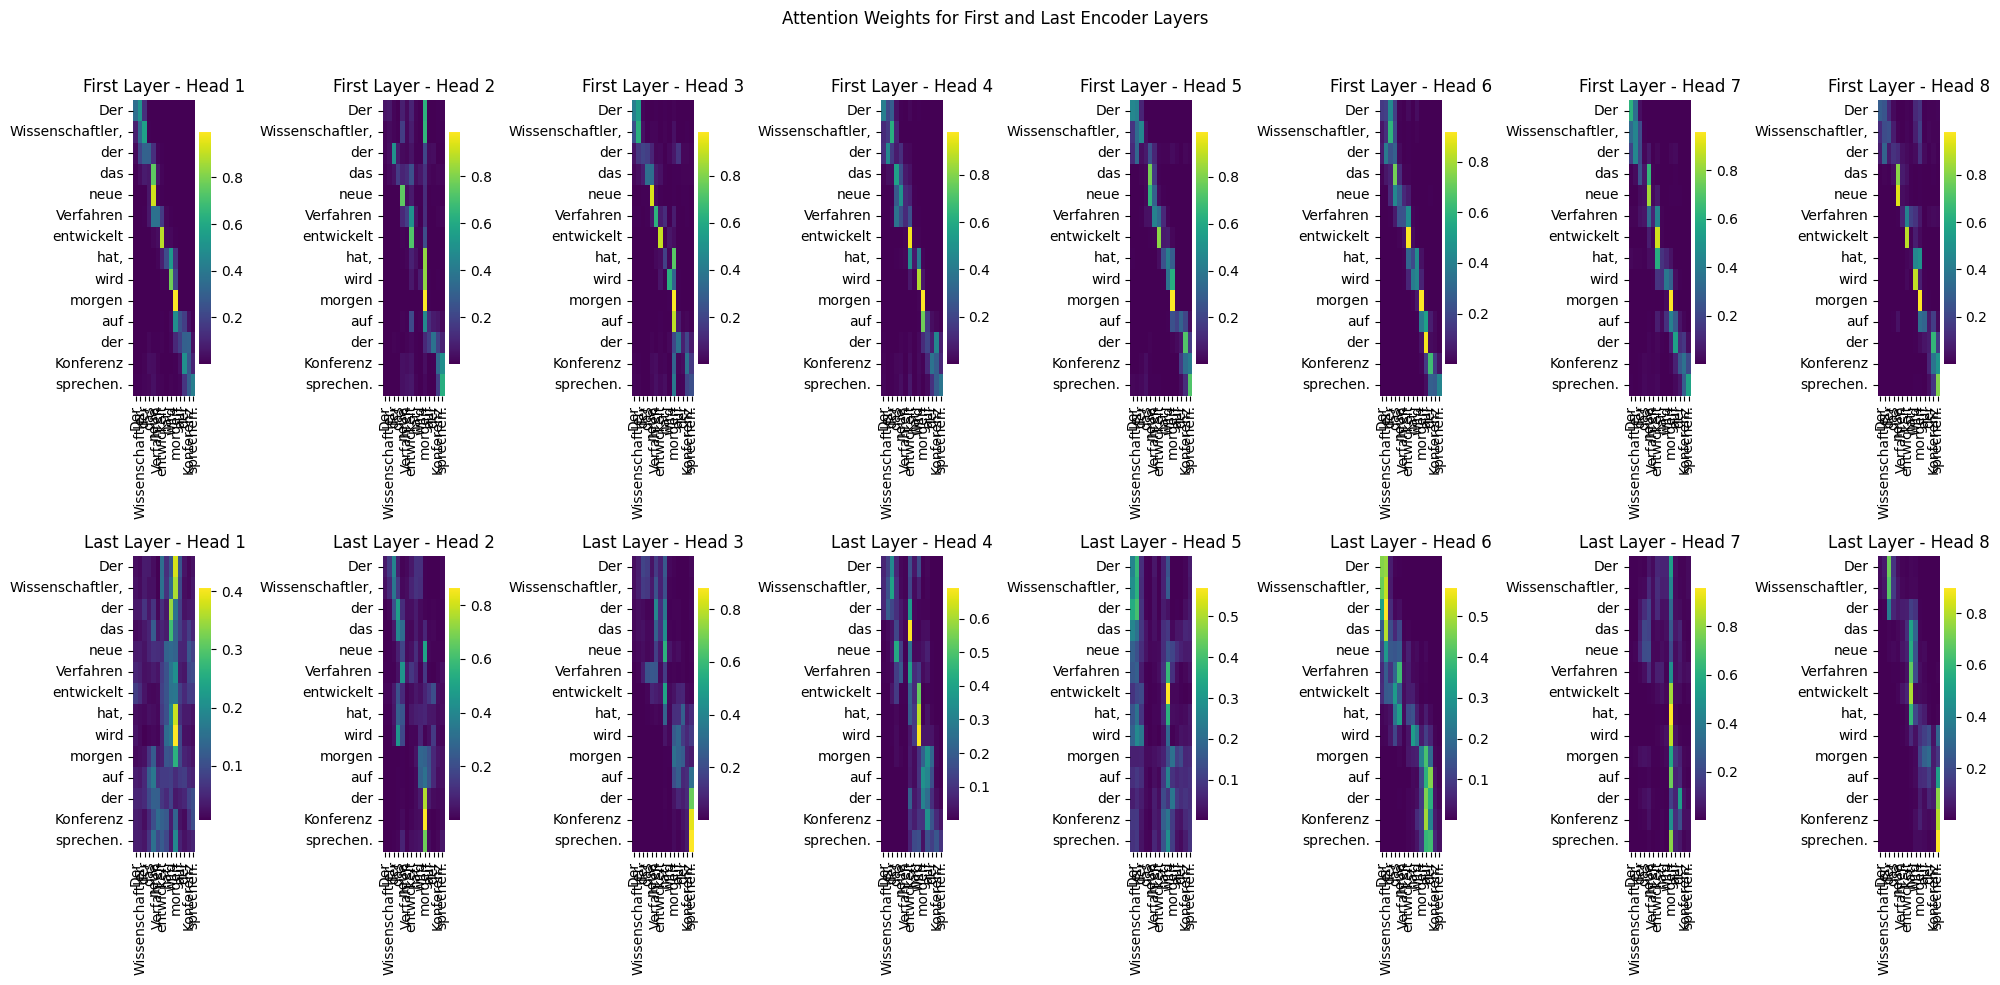

In [38]:
# Setup and configurations
device = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")

# Define the German and English sentences
german_sentence = ["Der", "Wissenschaftler,", "der", "das", "neue", "Verfahren", "entwickelt", "hat,", "wird", "morgen", "auf", "der", "Konferenz", "sprechen."]
english_sentence = "The scientist who developed the new method will speak at the conference tomorrow."

# Build vocabularies and tokenize the sentence
german_vocab = build_vocab([german_sentence], "de")
english_vocab = build_vocab([english_sentence.split()], "en")
src_vocab = german_vocab
src_tokens = [src_vocab[word] for word in german_sentence]

# Create a tensor from the tokenized sentence
src_tensor = torch.tensor(src_tokens, dtype=torch.long, device=device).unsqueeze(0)

# Define the model and load pretrained weights
src_vocab_size, tgt_vocab_size = 16181, len(english_vocab)
model = make_model(src_vocab_size, tgt_vocab_size).to(device)

# Load the pretrained weights (adjust the path if necessary)
model_weights_path = "model_epoch_15.pt"
folder_path = os.path.join(os.getcwd(), 'model_weights')
full_weights_path = os.path.join(folder_path, model_weights_path)
model.load_state_dict(torch.load(full_weights_path, map_location=device))
model.eval()

# Generate the source mask
src_mask = (src_tensor != get_special_tokens()["<blank>"]).unsqueeze(-2).to(device)

# Function to visualize attention weights
def visualize_attention_weights(model, src_tensor, src_mask, src_vocab):
    with torch.no_grad():
        # Forward pass through the encoder to populate attention weights
        model.encode(src_tensor, src_mask)

    # Retrieve attention weights from the first and last encoder layers
    first_layer_attn = model.encoder.layers[0].self_attn.attn[0].cpu().numpy()
    last_layer_attn = model.encoder.layers[-1].self_attn.attn[0].cpu().numpy()

    num_heads = first_layer_attn.shape[0]
    src_tokens = [word for word in german_sentence]

    fig, axes = plt.subplots(2, num_heads, figsize=(20, 10))

    for i in range(num_heads):
        # First layer attention heads
        sns.heatmap(first_layer_attn[i], xticklabels=src_tokens, yticklabels=src_tokens, ax=axes[0, i], cmap="viridis")
        axes[0, i].set_title(f"First Layer - Head {i+1}")
        axes[0, i].tick_params(axis='x', rotation=90)

        # Last layer attention heads
        sns.heatmap(last_layer_attn[i], xticklabels=src_tokens, yticklabels=src_tokens, ax=axes[1, i], cmap="viridis")
        axes[1, i].set_title(f"Last Layer - Head {i+1}")
        axes[1, i].tick_params(axis='x', rotation=90)

    fig.suptitle("Attention Weights for First and Last Encoder Layers")
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Visualize attention weights
visualize_attention_weights(model, src_tensor, src_mask, src_vocab)


The attention weights reveal how it learns linguistic structures and meaning progressively across layers. In the first encoder layer, attention heads focus on nearby tokens, capturing local grammatical relationships, such as article-noun pairs or prepositions, which are crucial for the German sentence structure. This layer shows the model’s initial focus on shorter-range dependencies and basic syntactic structures, forming the foundation for understanding word-level relationships in sentences.

By the final encoder layer, attention heads capture long-range dependencies and focus on key semantic components of the sentence. The model is able to grasp subject-verb-object relations and core meaning elements. Each attention head specializes in different aspects—some track syntactic patterns, while others emphasize main entities and actions, providing a multi-dimensional understanding. This hierarchical approach enables the model to accurately represent complex German sentence structures and generate fluent translations by balancing both structure and meaning.

### 5.2. Visualizing Encoder-Decoder Cross-Attention Map [5 points - Non-Programming]

Use the same translation as in the previous question.
German: "Der Wissenschaftler, der das neue Verfahren entwickelt hat, wird morgen auf der Konferenz sprechen."
English: "The scientist who developed the new method will speak at the conference tomorrow."

Using your trained transformer, visualize the attention weights for the cross-attention layer for the first and last layer of the decoder. You will have multiple attention heads, display all of them as heatmap, for both the layers. Clearly label the heatmap. You should have `2*num_heads` subplots, where the two rows represent two layers (add the index of the layer), and each column represent an attention head. In each subplot, have a heatmap denoting the attention matrix.

Explain the patterns you observe in the attention weights. What can you infer about the input and model's learning process from these attention weights?

**How to do this?**
- Each decoder will have decoder blocks. Take the first and the last decoder block.
- In each decoder block, you should have a cross-attention layer, and in each cross-attention layer, you should have an attention map for each head, which you would have initialized in `self.attn` class-level variable using the second return value of `attention` function.
- You essentially need to do a forward pass using the german sentence (after tokenizing) and the english sentence (after tokenizing), and take this attention map for the above two layers. The output should be heatmap plot of `german_sequence_length x english_sequence_length` for each head in each layer. You can use `seaborn` or `matplotlib` for this visualization.

You can add as many code or markdown cells as you need.



In [ ]:
# TODO: Implement the visualization of the attention weights for the cross-attention layer
# YOUR CODE HERE
# Example Heatmap Generation Code
# matrix = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

# # Display heatmap using Matplotlib
# plt.imshow(matrix, cmap='hot', interpolation='nearest')
# plt.colorbar()  # Add a color bar to show the scale
# plt.title('Heatmap using Matplotlib')
# plt.show()

<ipython-input-54-c80f0f3430f5>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(full_weights_path, map_location=device))


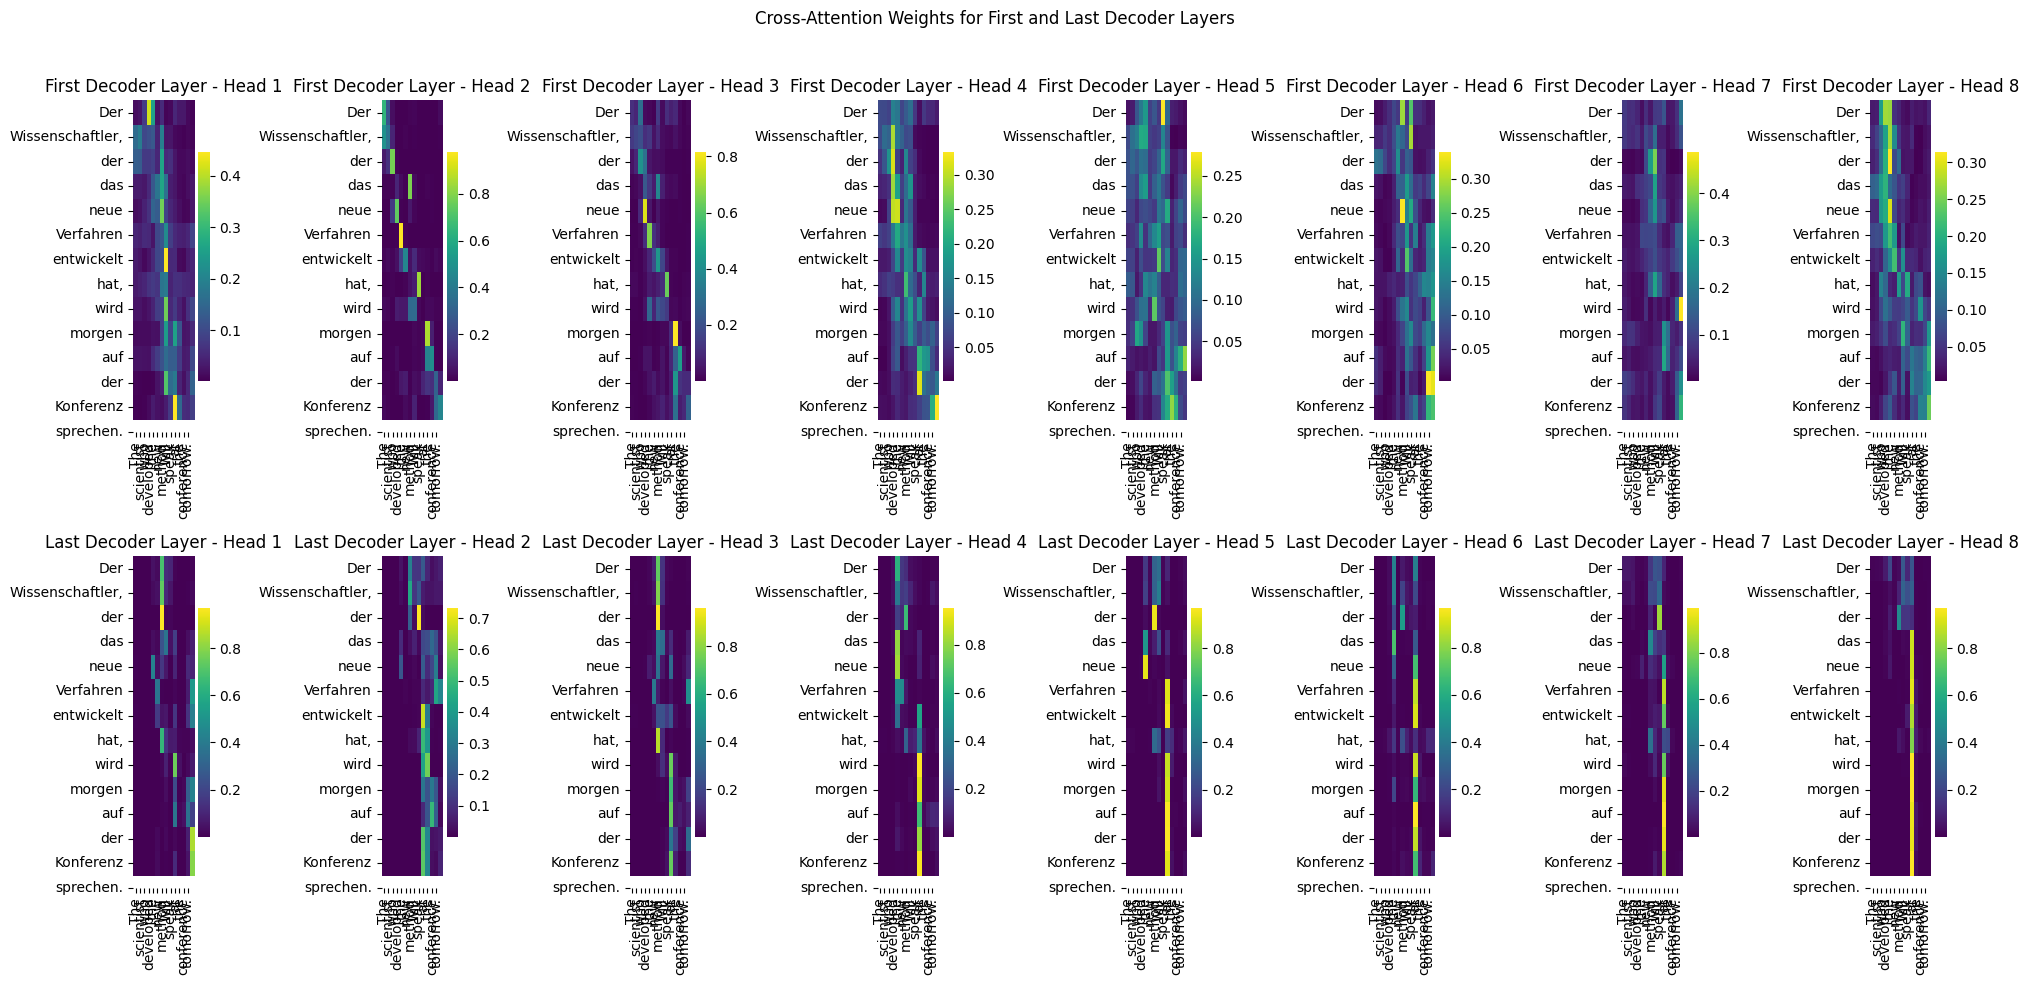

In [ ]:
# Tokenize the sentences
src_tokens = [german_vocab[word] for word in german_sentence]
tgt_tokens = [english_vocab[word] for word in english_sentence.split()]

# Create tensors from the tokenized sentences
src_tensor = torch.tensor(src_tokens, dtype=torch.long, device=device).unsqueeze(0)
tgt_tensor = torch.tensor(tgt_tokens, dtype=torch.long, device=device).unsqueeze(0)

# Define the model and load pretrained weights
src_vocab_size, tgt_vocab_size = 16181, 11503
model = make_model(src_vocab_size, tgt_vocab_size).to(device)

# Load the pretrained weights (adjust the path if necessary)
model_weights_path = "model_epoch_15.pt"
folder_path = os.path.join(os.getcwd(), 'model_weights')
full_weights_path = os.path.join(folder_path, model_weights_path)
model.load_state_dict(torch.load(full_weights_path, map_location=device))
model.eval()

# Generate the masks for the source and target
src_mask = (src_tensor != get_special_tokens()["<blank>"]).unsqueeze(-2).to(device)
tgt_mask = (tgt_tensor != get_special_tokens()["<blank>"]).unsqueeze(-2).to(device)
tgt_mask = tgt_mask & autoregressive_mask(tgt_tensor.size(1)).to(device)

# Function to visualize cross-attention weights
def visualize_attention_weights(model, src_tensor, tgt_tensor, src_mask, tgt_mask, src_vocab, tgt_vocab):
    with torch.no_grad():
        # Forward pass through the model to populate attention weights
        memory = model.encode(src_tensor, src_mask)
        model.decode(memory, src_mask, tgt_tensor, tgt_mask)

    # Retrieve attention weights from the first and last decoder layers
    first_layer_cross_attn = model.decoder.layers[0].cross_attn.attn[0].cpu().numpy()
    last_layer_cross_attn = model.decoder.layers[-1].cross_attn.attn[0].cpu().numpy()

    num_heads = first_layer_cross_attn.shape[0]
    src_tokens = [word for word in german_sentence]
    tgt_tokens = [word for word in english_sentence.split()]

    fig, axes = plt.subplots(2, num_heads, figsize=(20, 10))

    for i in range(num_heads):
        # First layer cross-attention heads
        sns.heatmap(
            first_layer_cross_attn[i],
            xticklabels=tgt_tokens,
            yticklabels=src_tokens,
            ax=axes[0, i],
            cmap="viridis",
            vmin=0, vmax=1,
            cbar=False
        )
        axes[0, i].set_title(f"First Layer - Head {i+1}")
        axes[0, i].tick_params(axis='x', rotation=90)

        # Last layer cross-attention heads
        sns.heatmap(
            last_layer_cross_attn[i],
            xticklabels=tgt_tokens,
            yticklabels=src_tokens,
            ax=axes[1, i],
            cmap="viridis",
            vmin=0, vmax=1,
            cbar=False
        )
        axes[1, i].set_title(f"Last Layer - Head {i+1}")
        axes[1, i].tick_params(axis='x', rotation=90)

    # Add space to the layout
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    fig.suptitle("Cross-Attention Weights for First and Last Decoder Layers")
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Visualize cross-attention weights
visualize_cross_attention_weights(model, src_tensor, tgt_tensor, src_mask, tgt_mask, german_vocab, english_vocab)


The cross-attention visualizations reveal how our model processes and aligns information between the German source sentence and the English target translation. In the early decoder layers, attention heads tend to distribute focus broadly across multiple tokens in the source sentence, reflecting the model’s initial effort to gather contextual information without specific emphasis on any particular tokens. This broad attention pattern suggests that the model begins by seeking general contextual clues rather than making exact token alignments.

As we move to the final decoder layer, the attention becomes much more focused, with certain heads aligning strongly with specific content words in the source sentence that are semantically or syntactically relevant to the target word being generated. This transition from broad to targeted attention demonstrates the model’s hierarchical refinement process, where it starts with a general context and progressively learns to identify exact word relationships crucial for accurate translation. Overall, these attention patterns indicate that the model effectively captures dependencies and aligns structurally and semantically related tokens, showing its learned ability to map meaning between the two languages accurately.

### 5.3. Distribution of k in Top-p Sampling [5 points - Non-Programming]

Extend implementation of top-p sampling to identify the distribution of number of samples (k) when using:
- p = 0.5
- p= 0.8
- p = 0.9

Write your code below and print the mean and standard deviation of k in all the three cases using the validation set. Use your existing trained model for this analysis.

Note - Your results should execute from the code, and not just written in the form of markdown cells. You can add more code cells if you want.

Also, in a markdown cell, provide intuitive reasoning why the output is coming that way.

**How to do this?**
- Copy the existing `generate` and `sample_top_p` functions from `sequence_generator.py` to the notebook.
- Modify the `sample_top_p` function here to also return the number of tokens selected after the candidate tokens are sampled by making prob of tokens that don't meet the criteria to be 0.
- Iterate over your validation set.
- Collect the value of k for each call to `sample_top_p` and calculate the mean and standard deviation of that distribution.

You can add as many code or markdown cells as you need.

In [40]:
from sequence_generator import DecodingStrategy
from datautils import init_dataloaders, get_pad_id, BOS_ID, EOS_ID

# Load the pretrained model
src_vocab_size, tgt_vocab_size = 16181, 11503  # Adjust based on actual vocab sizes
model = make_model(src_vocab=src_vocab_size, tgt_vocab=tgt_vocab_size, n_blocks=6, d_model=512, d_ff=2048, h=8, dropout=0.1).to(device)

# Load the pretrained weights (adjust the path if necessary)
model_weights_path = "model_epoch_15.pt"
folder_path = os.path.join(os.getcwd(), 'model_weights')
full_weights_path = os.path.join(folder_path, model_weights_path)
model.load_state_dict(torch.load(full_weights_path, map_location=device))
model.eval()

# Initialize the validation dataloader
_, valid_dataloader, _, _ = init_dataloaders(training_hp=TrainingHyperParams(), device=device)


<ipython-input-40-7ef18e45101f>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(full_weights_path, map_location=device))


Loading de tokens from local file...
Loading en tokens from local file...
Number of training batches: 4792
Number of validation batches: 218


In [39]:
from model import autoregressive_mask

def generate(model, src, src_mask, p, max_len=50):
    """
    Performs batched autoregressive generation on the model's output using top-p sampling.
    Args:
        model (nn.Module): The trained model.
        src (torch.Tensor): The encoded source sequence tensor. Shape: [batch_size, seq_len, feature_dim]
        src_mask (torch.Tensor): The mask tensor for the source sequence. Shape: [batch_size, 1, seq_len]
        p (float): The cumulative probability threshold for top-p sampling.
        max_len (int): Maximum length of the output sequence.
    Returns:
        List[List[int]], List[int]: A batch of decoded sequences of tokens and the k values per step.
    """
    batch_size = src.size(0)
    out_tokens = torch.full((batch_size, 1), BOS_ID, dtype=torch.long).to(src.device)
    k_values = []

    for i in range(max_len - 1):  # -1 to account for the BOS token
        tgt_mask = autoregressive_mask(out_tokens.size(1)).to(src.device)

        # Pass through the decoder to get output probabilities for the next token
        decoder_output = model(src=src, tgt=out_tokens, src_mask=src_mask, tgt_mask=tgt_mask)
        prob = model.generator(decoder_output[:, -1, :]).exp()

        # Apply top-p sampling and retrieve k value
        next_word, _, k = sample_top_p(prob, p=p)
        k_values.append(k)

        # Append the next word to the output sequence
        out_tokens = torch.cat([out_tokens, next_word.unsqueeze(1)], dim=1)

        # Break if all sequences have generated the EOS token
        if (next_word == EOS_ID).all():
            break

    # Remove tokens after the EOS token
    decoded_sequences = []
    for sequence in out_tokens:
        seq = sequence.tolist()
        if EOS_ID in seq:
            seq = seq[:seq.index(EOS_ID) + 1]
        decoded_sequences.append(seq)

    return decoded_sequences, k_values


In [46]:
def sample_top_p(prob, p=0.9):
    """
    Perform top-p sampling to get the next token index based on the probability distribution.
    Also returns the number of tokens (k) considered in the top-p subset for each item in the batch.
    """
    # Sort the probabilities in descending order
    sorted_probs, sorted_indices = torch.sort(prob, descending=True, dim=-1)

    # Calculate cumulative probability and identify the cutoff for top-p
    cumulative_probs = torch.cumsum(sorted_probs, dim=-1)
    top_p_mask = cumulative_probs <= p

    # Ensure at least one token is included
    top_p_mask[..., 1:] = top_p_mask[..., :-1].clone()
    top_p_mask[..., 0] = True

    # Zero out probabilities not in top-p and renormalize
    filtered_probs = sorted_probs * top_p_mask
    filtered_probs = filtered_probs / filtered_probs.sum(dim=-1, keepdim=True)

    # Sample from the renormalized top-p probabilities
    sampled_indices = torch.multinomial(filtered_probs, 1).squeeze(-1)

    # Map back to the global indices and retrieve log probabilities
    next_word = sorted_indices.gather(-1, sampled_indices.unsqueeze(-1)).squeeze(-1)
    log_probability_of_next_word = filtered_probs.gather(-1, sampled_indices.unsqueeze(-1)).log().squeeze(-1)

    # Calculate number of tokens in top-p subset (k) for each item in the batch
    k = top_p_mask.sum(dim=-1)

    return next_word, log_probability_of_next_word, k

In [47]:
def k_distribution_using_top_p(p=None):
    mean = None
    std = None
    # TODO: Implement the function to calculate the distribution of k for top-p sampling
    # YOUR CODE HERE (you can also add more cells, or code outside this boundary)
    k_values = []

    for batch in valid_dataloader:
        src, tgt = batch.src.to(device), batch.tgt.to(device)
        src_mask = batch.src_mask.to(device)

        # Generate using top-p sampling and collect k values
        _, batch_k_values = generate(model, src, src_mask, p=p)
        # Flatten batch_k_values and add individual counts to k_values
        for k in batch_k_values:
            k_values.extend(k.tolist())

    # Convert k_values to a single tensor for mean and std calculations
    k_values = torch.tensor(k_values, dtype=torch.float)

    # Calculate mean and std deviation of k values
    mean = torch.mean(k_values)
    std = torch.std(k_values)


    # END YOUR CODE
    return mean, std

In [48]:
mean_p1, std_p1 = k_distribution_using_top_p(0.5)
mean_p2, std_p2 = k_distribution_using_top_p(0.8)
mean_p3, std_p3 = k_distribution_using_top_p(0.9)

print(f'Mean and Standard Deviation for p=0.5: {mean_p1}, {std_p1}')
print(f'Mean and Standard Deviation for p=0.8: {mean_p2}, {std_p2}')
print(f'Mean and Standard Deviation for p=0.9: {mean_p3}, {std_p3}')

Mean and Standard Deviation for p=0.5: 4.460034370422363, 27.088623046875
Mean and Standard Deviation for p=0.8: 302.8497009277344, 558.6293334960938
Mean and Standard Deviation for p=0.9: 1873.0562744140625, 2017.6253662109375


In top-p sampling, setting a low threshold means only the highest-probability tokens are included, leading to a small average k with low variability, as fewer tokens are needed to meet the threshold. As p increases to values like 0.8 or 0.9, more tokens are required to reach the cumulative probability, resulting in a larger mean k and higher standard deviation, reflecting increased diversity in selection. In essence, higher p values allow for greater token variety, increasing both the number of tokens considered and the flexibility in the model's output choices at each step.

### 5.4. Distribution of p in Top-k Sampling [5 points - Non-Programming]

Extend and reprogram the implementation of top-k sampling to identify the distribution of cumulative probability of the samples (p) filtered when using:
- k = 1
- k = 3
- k = 5

- Write your code below and print the mean and standard deviation of p in all the three cases. Use your existing trained model for this analysis.

Note - Your results should execute from the code, and not just written in the form of markdown cells. You can add more code cells if you want.

Also, in a markdown cell, provide intuitive reasoning why the output is coming that way.

**How to do this?**
- Copy the existing `generate` and `sample_top_k` functions from `sequence_generator.py` to the notebook.
- Modify the `sample_top_k` function here to also return the cumulative probability of the samples selected after the candidate tokens are sampled. This is after selecting top_k tokens and making prob of tokens that don't meet the criteria to be 0, but before renormalizing the probabilities (since after renormalizing, probability will be 1 only).
- Iterate over your validation set.
- Collect the value of p for each call to `sample_top_k` and calculate the mean and standard deviation of that distribution.

You can add as many code or markdown cells as you need.

In [41]:
def generate_top_k(model, src, src_mask, k, max_len=50):
    """
    Generates a sequence using top-k sampling and collects the cumulative probability (p) for the selected tokens.
    Args:
        model (nn.Module): The trained model.
        src (torch.Tensor): The encoded source sequence tensor. Shape: [batch_size, seq_len, feature_dim]
        src_mask (torch.Tensor): The mask tensor for the source sequence. Shape: [batch_size, 1, seq_len]
        k (int): The number of top tokens to consider for sampling.
        max_len (int): Maximum length of the output sequence.
    Returns:
        List[List[int]], List[float]: A batch of decoded sequences of tokens and the cumulative probabilities (p) per step.
    """
    batch_size = src.size(0)
    out_tokens = torch.full((batch_size, 1), BOS_ID, dtype=torch.long).to(src.device)
    cumulative_probs = []

    for i in range(max_len - 1):  # -1 to account for the BOS token
        tgt_mask = autoregressive_mask(out_tokens.size(1)).to(src.device)

        # Pass through the decoder to get output probabilities for the next token
        decoder_output = model(src=src, tgt=out_tokens, src_mask=src_mask, tgt_mask=tgt_mask)
        prob = (model.generator(decoder_output[:, -1, :]).exp().round(decimals=2) * 100).int()

        # Apply top-k sampling and retrieve cumulative probability
        next_word, _, cum_prob = sample_top_k(prob, k=k)
        cumulative_probs.append(cum_prob)

        # Append the next word to the output sequence
        out_tokens = torch.cat([out_tokens, next_word.unsqueeze(1)], dim=1)

        # Break if all sequences have generated the EOS token
        if (next_word == EOS_ID).all():
            break

    # Remove tokens after the EOS token
    decoded_sequences = []
    for sequence in out_tokens:
        seq = sequence.tolist()
        if EOS_ID in seq:
            seq = seq[:seq.index(EOS_ID) + 1]
        decoded_sequences.append(seq)

    return decoded_sequences, cumulative_probs

In [42]:
def sample_top_k(prob, k=1):
    """
    Perform top-k sampling and return the cumulative probability of the selected tokens.
    """
    # Sort the probabilities in descending order
    sorted_probs, sorted_indices = torch.sort(prob, descending=True, dim=-1)

    # Take only the top-k probabilities and indices
    top_k_probs = sorted_probs[:, :k]
    top_k_indices = sorted_indices[:, :k]

    # Calculate cumulative probability of selected top-k tokens as integers
    cum_prob = top_k_probs.sum(dim=-1).float() / 100

    # Renormalize probabilities within top-k
    top_k_probs = top_k_probs / top_k_probs.sum(dim=-1, keepdim=True)

    # Sample from the renormalized top-k probabilities
    sampled_indices = torch.multinomial(top_k_probs, 1).squeeze(-1)

    # Map back to the original vocabulary indices
    next_word = top_k_indices.gather(-1, sampled_indices.unsqueeze(-1)).squeeze(-1)

    return next_word, None, cum_prob

In [43]:
def p_distribution_using_top_k(k=None):
    mean = None
    std = None
    # TODO: Implement the function to calculate the distribution of cumulative probability (p) for top-k sampling
    cumulative_probs = []

    for batch in valid_dataloader:
        src, tgt = batch.src.to(device), batch.tgt.to(device)
        src_mask = batch.src_mask.to(device)

        # Generate using top-k sampling and collect cumulative probabilities
        _, batch_cumulative_probs = generate_top_k(model, src, src_mask, k=k)

        # Flatten batch_cumulative_probs and add individual probabilities to cumulative_probs
        for cum_prob in batch_cumulative_probs:
            cumulative_probs.extend(cum_prob.tolist())

    # Convert cumulative_probs to a single tensor for mean and std calculations
    cumulative_probs = torch.tensor(cumulative_probs, dtype=torch.float)

    # Calculate mean and std deviation of cumulative probabilities
    mean = torch.mean(cumulative_probs)
    std = torch.std(cumulative_probs)

    return mean, std

In [ ]:
mean_k1, std_k1 = p_distribution_using_top_k(k=1)

In [55]:
print(f'Mean and Standard Deviation for k=1: {mean_k1}, {std_k1}')

Mean and Standard Deviation for k=1: 0.6269394755363464, 0.23370222747325897


In [44]:
mean_k2, std_k2 = p_distribution_using_top_k(k=3)

In [45]:
print(f'Mean and Standard Deviation for k=3: {mean_k2}, {std_k2}')

Mean and Standard Deviation for k=3: 0.7739812731742859, 0.15998463332653046


In [46]:
mean_k3, std_k3 = p_distribution_using_top_k(k=5)

In [47]:
print(f'Mean and Standard Deviation for k=5: {mean_k3}, {std_k3}')

Mean and Standard Deviation for k=5: 0.788227379322052, 0.14594563841819763


The results indicate that as the top-k value increases, both the mean cumulative probability and stability (measured by the standard deviation) of the sampling process improve. For k=1, we see a lower mean cumulative probability and a higher standard deviation. This reflects the deterministic nature of single-token sampling, where only the most probable token is selected. Consequently, the model’s confidence level for individual tokens can vary significantly, leading to higher variability in cumulative probability values.

As we increase to k=3 and k=5, the mean cumulative probability rises, while the standard deviation decreases. This pattern shows that including additional tokens allows the model to sample from a larger probability mass, making the cumulative probabilities more stable and closer to the threshold. By k=5, the distribution is relatively stable and includes a balanced range of probable tokens, reducing the chance of extreme shifts in probability values. Overall, increasing k broadens the sampling pool, providing a balance between diversity and consistency in token selection and creating a more predictable sampling behavior.

## 6. Group Query Attention [15 points - Non-Programming] (Bonus)

Group Query Attention (GQA) is a variation of self-attention designed to reduce computational and memory overhead, primarily in transformer-based models. It simplifies the traditional multi-head attention mechanism by grouping multiple attention heads together and sharing parameters, particularly focusing on queries.

#### How GQA Works
In GQA, multiple attention heads use the same set of query vectors, but still maintain separate key and value vectors. By grouping the queries, the model reduces the number of parameters needed for attention computations while still allowing each head to attend to different parts of the input sequence using unique keys and values.

#### Difference Between GQA and Self-Attention

1. **MultiHead-Attention**:
   - In standard multi-head attention, every attention head has its own set of queries, keys, and values. This allows each head to learn different representations for the input sequence independently.
   - The query, key, and value vectors are projected independently for each head from the input embeddings.
   - Complexity scales with the number of attention heads, making it more computationally expensive.

2. **Group Query Attention (GQA)**:
   - In GQA, attention heads **share query vectors**, but keep separate key and value vectors. This significantly reduces the number of parameters.
   - The shared query mechanism means GQA heads focus on optimizing the key-value interaction while relying on the same query.
   - GQA offers a reduction in computational complexity and memory usage, making it more efficient than traditional self-attention, especially when scaling to larger models or sequences.

**Key Differences**:
- **Parameter Sharing**: GQA groups attention heads by sharing query vectors, while self-attention has independent queries for each head.
- **Efficiency**: GQA is more efficient in terms of memory and computation since fewer parameters are used, making it advantageous for scaling large models.
- **Learning Flexibility**: Self-attention provides more flexibility since each head can independently attend to different patterns in the input, whereas GQA might have slightly limited flexibility due to shared queries.

Read this 5-page paper on GQA for more details - [Group Query Attention](https://arxiv.org/pdf/2305.13245). Based on this, implement the following:

1. Using the `attention` function in the `transformer.py` file, implement a new class `GroupQueryAttention` (like `MultiHeadAttention`) that performs Group Query Attention, following the ideas of the paper. The forward of the function should return the attention scores and the context vectors. [5 points]
2. Initialize a transformer model with the `GroupQueryAttention` class and train it on the dataset. The training curve should move towards convergence and validation loss should be decreasing. [5 points]
3. Compare the performance of the model with `GroupQueryAttention` and the original model on the validation set using BLEU score. Use any decoding strategy that you like. [5 points]

Add as many code cells below. You can also add markdown cells to explain your code and results.

In [ ]:
# YOUR CODE HERE (add more cells as needed)
# TODO: Implement Group Query Attention

## 7. Submit Your Assignment

This is the end. Congratulations!

Now, follow the steps below to submit your homework on Gradescope.

### 7.1. Programming

The programming will be evaluated through an autograder. Submit the following files on autograder -
1. model.py
2. datautils.py
3. model_training.py
4. sequence_generator.py
5. utils.py
5. All the CSV files inside `outputs` directory for BLEU score evaluation.

### 7.2. Non-Programming

The analysis parts will be evaluated manually. For this, export the notebook to a PDF file, and submit it on GradeScope. Please ensure no written code or output is clipped when you create your PDF. One reliable way to do it is first download it as HTML through Jupyter Notebook and then print it to get PDF.